# Pre-processing steps from raw data of Underwater Vision Profiler 5
- data downloaded and merged from https://doi.pangaea.de/10.1594/PANGAEA.924375
- additional data provided by Dr. Rainer Kiko (2022 to 2025)

In [2]:
# 1) load merged df 2008-2025 data
import pandas as pd
df = pd.read_pickle('../../Data/Ecopart_data_merged_2008_2025.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4055302 entries, 0 to 4055301
Data columns (total 70 columns):
 #   Column                                        Dtype         
---  ------                                        -----         
 0   Pressure [dbar]                               float64       
 1   Date_Time                                     object        
 2   Biovolume [mm3 l-1] (ESD: 0.064-0.0806 mm)    float64       
 3   Part conc frac [#/l] (ESD: 0.406-0.512 mm)    float64       
 4   Part conc frac [#/l] (ESD: 5.16-6.5 mm)       float64       
 5   Biovolume [mm3 l-1] (ESD: 1.02-1.29 mm)       float64       
 6   Cruise                                        object        
 7   Biovolume [mm3 l-1] (ESD: 0.102-0.128 mm)     float64       
 8   Project_id                                    object        
 9   CTD_filename                                  object        
 10  Profile                                       object        
 11  Part conc frac [#/l] (ES

## Remove 1-count abudnance and biovolume estimates
Kiko et al. 2022: "To further define the upper limit of the size spectrum,  one could also set the abundance and biovolume estimate to “nan” (not a number) if only one particle was observed in the aggregated volume. The count of particles per size bin can be computed by multiplying the particle abundance and observed volume. "

- Part conc frac ['/l] = number of particles per L
    - multiply * Volume sampeled = absolute count

Remaining Profile_id + Pressure duplicates: 0
Size classes in order:
 1. 0.0403 - 0.0508 mm
 2. 0.0508 - 0.064 mm
 3. 0.064 - 0.0806 mm
 4. 0.0806 - 0.102 mm
 5. 0.102 - 0.128 mm
 6. 0.128 - 0.161 mm
 7. 0.161 - 0.203 mm
 8. 0.203 - 0.256 mm
 9. 0.256 - 0.323 mm
10. 0.323 - 0.406 mm
11. 0.406 - 0.512 mm
12. 0.512 - 0.645 mm
13. 0.645 - 0.813 mm
14. 0.813 - 1.02 mm
15. 1.02 - 1.29 mm
16. 1.29 - 1.63 mm
17. 1.63 - 2.05 mm
18. 2.05 - 2.58 mm
19. 2.58 - 3.25 mm
20. 3.25 - 4.1 mm
21. 4.1 - 5.16 mm
22. 5.16 - 6.5 mm
23. 6.5 - 8.19 mm
24. 8.19 - 10.3 mm
25. 10.3 - 13.0 mm
26. 13.0 - 16.4 mm
27. 16.4 - 20.6 mm
28. 20.6 - 26.0 mm

Data quality control: Setting abundance and biovolume to NaN for single particle observations
Size class  0.0403-0.0508 mm:
  Original valid observations: 4054840
  Filtered (single particle): 0
  Remaining valid: 4054840
  Percent filtered: 0.0%

Size class  0.0508-0.064 mm:
  Original valid observations: 4054840
  Filtered (single particle): 0
  Remaining valid: 405

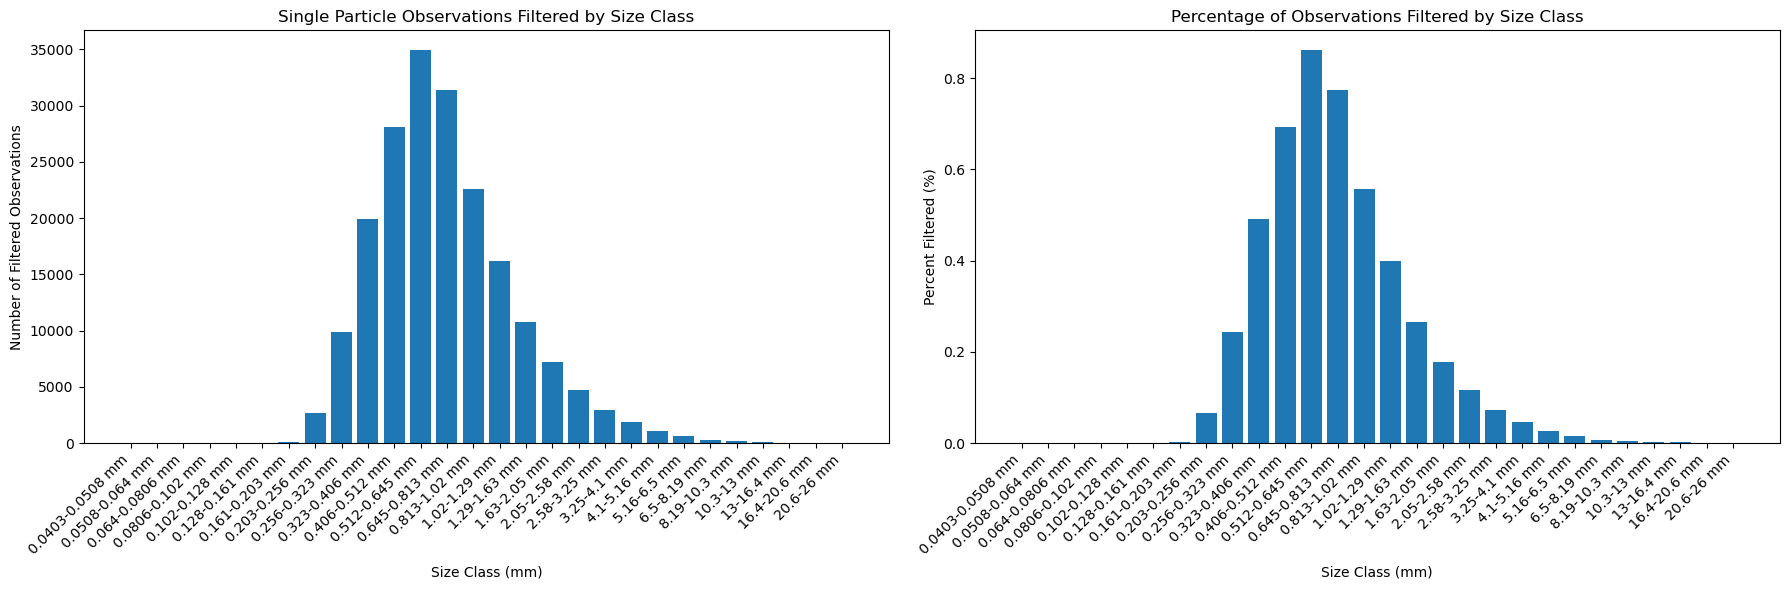


Reordering columns in the dataset...
Column reordering complete. Size classes now ordered from smallest to largest.

Size class column order in final dataset:
 1.  0.0403-0.0508 mm
 2.  0.0508-0.064 mm
 3.  0.064-0.0806 mm
 4.  0.0806-0.102 mm
 5.  0.102-0.128 mm
 6.  0.128-0.161 mm
 7.  0.161-0.203 mm
 8.  0.203-0.256 mm
 9.  0.256-0.323 mm
10.  0.323-0.406 mm
11.  0.406-0.512 mm
12.  0.512-0.645 mm
13.  0.645-0.813 mm
14.  0.813-1.02 mm
15.  1.02-1.29 mm
16.  1.29-1.63 mm
17.  1.63-2.05 mm
18.  2.05-2.58 mm
19.  2.58-3.25 mm
20.  3.25-4.1 mm
21.  4.1-5.16 mm
22.  5.16-6.5 mm
23.  6.5-8.19 mm
24.  8.19-10.3 mm
25.  10.3-13 mm
26.  13-16.4 mm
27.  16.4-20.6 mm
28.  20.6-26 mm

Filtered and ordered dataset saved as: ../../Data/Ecopart_data_merged_2008_2025_filtered.pkl


In [9]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import re

# Read the data
df_merged = df.copy()
df_merged["Profile_id"] = df_merged["Profile_id"].astype(str)

# now check for duplicates in Profile_id + Pressure [dbar]
dupes = df_merged.duplicated(subset=['Profile_id', 'Pressure [dbar]'])
print(f"Remaining Profile_id + Pressure duplicates: {dupes.sum()}")

# List of abundance and corresponding biovolume columns for the selected size classes
abundance_cols = [col for col in df_merged.columns if col.startswith("Part conc frac [#/l] (ESD:")]
biovolume_cols = [col.replace("Part conc frac [#/l]", "Biovolume [mm3 l-1]") for col in abundance_cols]

def extract_size_range(column_name):
    """Extract the lower and upper bounds from ESD size range"""
    # Extract the ESD range from column name
    match = re.search(r'ESD:\s*([\d.]+)-([\d.]+|>[\d.]+)\s*mm', column_name)
    if match:
        lower = float(match.group(1))
        upper_str = match.group(2)
        if upper_str.startswith('>'):
            upper = float('inf')  # For open-ended ranges like ">26 mm"
        else:
            upper = float(upper_str)
        return lower, upper
    return None, None

def sort_columns_by_size(columns):
    """Sort columns by their ESD size ranges"""
    column_data = []
    for col in columns:
        lower, upper = extract_size_range(col)
        if lower is not None:
            column_data.append((col, lower, upper))
    
    # Sort by lower bound, then by upper bound
    column_data.sort(key=lambda x: (x[1], x[2]))
    return [item[0] for item in column_data]

# Sort the columns by size
abundance_cols_sorted = sort_columns_by_size(abundance_cols)
biovolume_cols_sorted = [col.replace("Part conc frac [#/l]", "Biovolume [mm3 l-1]") for col in abundance_cols_sorted]

print("Size classes in order:")
for i, col in enumerate(abundance_cols_sorted):
    lower, upper = extract_size_range(col)
    if upper == float('inf'):
        print(f"{i+1:2d}. {lower} - >26 mm")
    else:
        print(f"{i+1:2d}. {lower} - {upper} mm")

# Get the volume column name
volume_col = "Vol [L] (sampled for this depth bin)"

print("\nData quality control: Setting abundance and biovolume to NaN for single particle observations")
print("=" * 80)

# Store statistics for summary
filtering_stats = {}
total_filtered = 0

# Use the sorted columns
for a_col, b_col in zip(abundance_cols_sorted, biovolume_cols_sorted):
    # Calculate particle count per bin
    particle_count = df_merged[a_col] * df_merged[volume_col]
    
    # Find bins with only one observed particle
    single_particle_mask = particle_count == 1
    
    # Store original counts for statistics
    original_valid = df_merged[a_col].notna().sum()
    
    # Set abundance and biovolume to NaN where only one particle observed
    df_merged.loc[single_particle_mask, a_col] = np.nan
    df_merged.loc[single_particle_mask, b_col] = np.nan
    
    # Calculate statistics
    num_filtered = single_particle_mask.sum()
    remaining_valid = df_merged[a_col].notna().sum()
    percent_filtered = (num_filtered / original_valid * 100) if original_valid > 0 else 0
    
    # Store stats with size information for proper ordering
    lower, upper = extract_size_range(a_col)
    size_class = a_col.split("(ESD:")[1].rstrip(")")
    filtering_stats[size_class] = {
        'filtered': num_filtered,
        'original_valid': original_valid,
        'remaining_valid': remaining_valid,
        'percent_filtered': percent_filtered,
        'lower_bound': lower,
        'upper_bound': upper,
        'column_name': a_col
    }
    
    total_filtered += num_filtered
    
    # Print detailed results
    print(f"Size class {size_class}:")
    print(f"  Original valid observations: {original_valid}")
    print(f"  Filtered (single particle): {num_filtered}")
    print(f"  Remaining valid: {remaining_valid}")
    print(f"  Percent filtered: {percent_filtered:.1f}%")
    print()

print("=" * 80)
print(f"SUMMARY:")
print(f"Total observations filtered: {total_filtered}")
print(f"Size classes processed: {len(abundance_cols_sorted)}")

# Create ordered lists for plotting
size_classes_ordered = []
filtered_counts_ordered = []
percentages_ordered = []

# Sort the filtering stats by size
for col in abundance_cols_sorted:
    size_class = col.split("(ESD:")[1].rstrip(")")
    if size_class in filtering_stats:
        size_classes_ordered.append(size_class)
        filtered_counts_ordered.append(filtering_stats[size_class]['filtered'])
        percentages_ordered.append(filtering_stats[size_class]['percent_filtered'])

# Create summary plot with properly ordered size classes
if len(filtering_stats) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # Plot absolute numbers
    ax1.bar(range(len(size_classes_ordered)), filtered_counts_ordered)
    ax1.set_xlabel('Size Class (mm)')
    ax1.set_ylabel('Number of Filtered Observations')
    ax1.set_title('Single Particle Observations Filtered by Size Class')
    ax1.set_xticks(range(len(size_classes_ordered)))
    ax1.set_xticklabels(size_classes_ordered, rotation=45, ha='right')
    
    # Plot percentages
    ax2.bar(range(len(size_classes_ordered)), percentages_ordered)
    ax2.set_xlabel('Size Class (mm)')
    ax2.set_ylabel('Percent Filtered (%)')
    ax2.set_title('Percentage of Observations Filtered by Size Class')
    ax2.set_xticks(range(len(size_classes_ordered)))
    ax2.set_xticklabels(size_classes_ordered, rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

# Reorder the columns in the dataframe to maintain size ordering
print("\nReordering columns in the dataset...")

# Get all other columns (non-size-class columns)
other_cols = [col for col in df_merged.columns 
              if not (col.startswith("Part conc frac [#/l] (ESD:") or 
                     col.startswith("Biovolume [mm3 l-1] (ESD:"))]

# Create the final column order: other columns + sorted size class columns
final_column_order = other_cols.copy()

# Add abundance and biovolume columns in pairs, sorted by size
for a_col in abundance_cols_sorted:
    b_col = a_col.replace("Part conc frac [#/l]", "Biovolume [mm3 l-1]")
    if a_col in df_merged.columns:
        final_column_order.append(a_col)
    if b_col in df_merged.columns:
        final_column_order.append(b_col)

# Reorder the dataframe
df_merged_ordered = df_merged[final_column_order]

print(f"Column reordering complete. Size classes now ordered from smallest to largest.")

# Verify the ordering
print("\nSize class column order in final dataset:")
size_cols_in_final = [col for col in df_merged_ordered.columns 
                     if col.startswith("Part conc frac [#/l] (ESD:")]
for i, col in enumerate(size_cols_in_final):
    lower, upper = extract_size_range(col)
    size_range = col.split("(ESD:")[1].rstrip(")")
    print(f"{i+1:2d}. {size_range}")

# Save the filtered and properly ordered dataset
df_merged_ordered.to_pickle('../../Data/Ecopart_data_merged_2008_2025_filtered.pkl')
print(f"\nFiltered and ordered dataset saved as: {'../../Data/Ecopart_data_merged_2008_2025_filtered.pkl'}")


# Re-caclulate Biovolume from Particle concentrations

In [10]:
import pandas as pd
data = pd.read_pickle('../../Data/Ecopart_data_merged_2008_2025_filtered.pkl')
# remove all columns starting with "Biovolume"
data_sizes = data.loc[:, ~data.columns.str.startswith('Biovolume')]
data_sizes.info()

data_sizes["Profile_id"] = data_sizes["Profile_id"].astype(str)
print(f"Unique Profile_ids after addition: {data_sizes['Profile_id'].nunique()}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4055302 entries, 0 to 4055301
Data columns (total 40 columns):
 #   Column                                        Dtype         
---  ------                                        -----         
 0   Pressure [dbar]                               float64       
 1   Date_Time                                     object        
 2   Cruise                                        object        
 3   Project_id                                    object        
 4   CTD_filename                                  object        
 5   Profile                                       object        
 6   RAWfilename                                   object        
 7   Vol [L] (sampled for this depth bin)          float64       
 8   Profile_id                                    object        
 9   Longitude                                     float64       
 10  datetime                                      datetime64[ns]
 11  Latitude                

C:\Users\bthobor\AppData\Local\Temp\ipykernel_33596\2084246100.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sizes["Profile_id"] = data_sizes["Profile_id"].astype(str)


In [11]:
import numpy as np

# function from paruvpy package (Rainer Kiko)
def esd_to_vol(esd): # equivalent spherical diameter (esd) in mm to volume in cubic mm
    radius = esd/2.0
    volume = np.power(radius, 3.0)*np.pi*4.0/3.0
    return volume

# function adapted from paruvpy package (Rainer Kiko)
def calculate_BV_per_size_class(size_class_input):

    #size_class_input format is "Part conc frac [#/l] (ESD: 0.102-0.128 mm)"

    esd_input = size_class_input.replace("Part conc frac [#/l] (ESD: ","").replace(" mm)","")
    esd_input_list = esd_input.split("-") 
    esd_start = float(esd_input_list[0]) # start of size class in mm
    esd_end = float(esd_input_list[1])   # end of size class in mm

    flux_vol_start = esd_to_vol(esd_start)  # volume in cubic mm starting size
    flux_vol_end = esd_to_vol(esd_end)      # volume in cubic mm ending size
    med = (flux_vol_start + flux_vol_end)/2 # median volume in cubic mm
    return med

# result is the median volume in mm^3 for a single particle in a given size class
## result needs to be multiplied with number of particles /L to get the target unit mm^3/L which equals ppm
## final unit for Biovolume is ppm = mm^3/L
### then loop over all size classes and sum to get total Biovolume

In [12]:
# create a list of column names of data_sizes
size_class_columns = data_sizes.columns.tolist()
# remove largest size class with >26 mm from list
size_class_columns = [x for x in size_class_columns if "Part conc frac" in x and not ">26" in x]

target_size_ranges = [
    '0.102-0.128', '0.128-0.161', '0.161-0.203', 
    '0.203-0.256', '0.256-0.323', '0.323-0.406', 
    '0.406-0.512', '0.512-0.645', '0.645-0.813',
    '0.813-1.02', '1.02-1.29', '1.29-1.63', 
    '1.63-2.05',  '2.05-2.58', '2.58-3.25', 
    '3.25-4.1','4.1-5.16',   '5.16-6.5', 
    '6.5-8.19', '8.19-10.3', '10.3-13', 
    '13-16.4', '16.4-20.6', '20.6-26'
]
# filter size_class_columns to only include those in target_size_ranges
size_class_columns = [x for x in size_class_columns if any(y in x for y in target_size_ranges)]

# create an empty dictionary to store Biovolume per size class
BV_per_size_class = {}

# calculate specific Biovolume per size class (once per column name)
for val in size_class_columns:
    if "Part conc frac" in val:
        BV_per_size_class[val] = calculate_BV_per_size_class(val)

print(BV_per_size_class)

{'Part conc frac [#/l] (ESD: 0.102-0.128 mm)': np.float64(0.0008268567144493215), 'Part conc frac [#/l] (ESD: 0.128-0.161 mm)': np.float64(0.001641595520635584), 'Part conc frac [#/l] (ESD: 0.161-0.203 mm)': np.float64(0.003282626078192298), 'Part conc frac [#/l] (ESD: 0.203-0.256 mm)': np.float64(0.006582328545052571), 'Part conc frac [#/l] (ESD: 0.256-0.323 mm)': np.float64(0.013214450548266376), 'Part conc frac [#/l] (ESD: 0.323-0.406 mm)': np.float64(0.026342695008720086), 'Part conc frac [#/l] (ESD: 0.406-0.512 mm)': np.float64(0.05265862836042057), 'Part conc frac [#/l] (ESD: 0.512-0.645 mm)': np.float64(0.1053883522715888), 'Part conc frac [#/l] (ESD: 0.645-0.813 mm)': np.float64(0.21093279352697364), 'Part conc frac [#/l] (ESD: 0.813-1.02 mm)': np.float64(0.4185061650051374), 'Part conc frac [#/l] (ESD: 1.02-1.29 mm)': np.float64(0.8398254707227282), 'Part conc frac [#/l] (ESD: 1.29-1.63 mm)': np.float64(1.6957887793081707), 'Part conc frac [#/l] (ESD: 1.63-2.05 mm)': np.float6

In [13]:
# Step 1: Calculate BV columns for each size class
print("Calculating BV columns for each size class...")

# Create a copy to avoid modifying the original dataframe
data_BV = data_sizes.copy()

# Find matching columns between data_BV and BV_per_size_class
matching_columns = [col for col in data_BV.columns if col in BV_per_size_class.keys()]
print(f"Found {len(matching_columns)} matching columns")

# Calculate BV for each matching column
BV_columns = []
for col in matching_columns:
    # multiply particle concentration with Biovolume per size class to get Biovolume in mm^3/L = ppm
    BV_col_name = col.replace('Part conc frac [#/l]', 'Biovolume [ppm]')
    data_BV[BV_col_name] = (data_BV[col] ) * BV_per_size_class[col]
    BV_columns.append(BV_col_name)
    print(f"Created BV column: {BV_col_name}")

# Step 2: Calculate total flux per row
print("Calculating total flux per row...")
data_BV['Biovolume [ppm]'] = data_BV[BV_columns].sum(axis=1)

# Step 3: Save the dataset with BV columns as pickle
print("Saving dataset with BV columns...")
data_BV.to_pickle("../../Data/Ecopart_data_with_BV.pkl")
print("Saved: ../../Data/Ecopart_data_with_BV.pkl")

Calculating BV columns for each size class...
Found 24 matching columns
Created BV column: Biovolume [ppm] (ESD: 0.102-0.128 mm)
Created BV column: Biovolume [ppm] (ESD: 0.128-0.161 mm)
Created BV column: Biovolume [ppm] (ESD: 0.161-0.203 mm)
Created BV column: Biovolume [ppm] (ESD: 0.203-0.256 mm)
Created BV column: Biovolume [ppm] (ESD: 0.256-0.323 mm)
Created BV column: Biovolume [ppm] (ESD: 0.323-0.406 mm)
Created BV column: Biovolume [ppm] (ESD: 0.406-0.512 mm)
Created BV column: Biovolume [ppm] (ESD: 0.512-0.645 mm)
Created BV column: Biovolume [ppm] (ESD: 0.645-0.813 mm)
Created BV column: Biovolume [ppm] (ESD: 0.813-1.02 mm)
Created BV column: Biovolume [ppm] (ESD: 1.02-1.29 mm)
Created BV column: Biovolume [ppm] (ESD: 1.29-1.63 mm)
Created BV column: Biovolume [ppm] (ESD: 1.63-2.05 mm)
Created BV column: Biovolume [ppm] (ESD: 2.05-2.58 mm)
Created BV column: Biovolume [ppm] (ESD: 2.58-3.25 mm)
Created BV column: Biovolume [ppm] (ESD: 3.25-4.1 mm)
Created BV column: Biovolume [

# Remove outliers

In [16]:
#!/usr/bin/env python3
"""
- Subset data to profiles reaching a minimum depth (1000 dbar) 
- cut off all profiles at  > 1000 dbar
- exclude all values at 2.5 dbar (light from surface can create artifacts)
- bin data by depth (25 dbar bins)
"""
import random
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize

# ----------------- TUNABLE PARAMETERS -----------------
bin_size = 25             # dbar bin size (tunable)
max_depth_threshold = 1000  # profiles must reach at least this depth
choose_column_prefix = "Biovolume"   # either "Biovolume" or "Part conc frac"
# manual_size_endings: specify how the size/range appears at the END of the column names.
manual_size_endings = [
    #" (ESD: 0.102-0.128 mm)", # small size classes can not be detected by all UVP instruments used in the dataset
    #" (ESD: 0.128-0.161 mm)",
    #" (ESD: 0.161-0.203 mm)",
    " (ESD: 0.203-0.256 mm)",
    " (ESD: 0.256-0.323 mm)",
    " (ESD: 0.323-0.406 mm)",
    " (ESD: 0.406-0.512 mm)",
    " (ESD: 0.512-0.645 mm)",
    " (ESD: 0.645-0.813 mm)",
    " (ESD: 0.813-1.02 mm)",
    " (ESD: 1.02-1.29 mm)",
    " (ESD: 1.29-1.63 mm)",
    " (ESD: 1.63-2.05 mm)",
    " (ESD: 2.05-2.58 mm)",
    " (ESD: 2.58-3.25 mm)",
    " (ESD: 3.25-4.1 mm)",
    " (ESD: 4.1-5.16 mm)",
    " (ESD: 5.16-6.5 mm)",
    " (ESD: 6.5-8.19 mm)",
    " (ESD: 8.19-10.3 mm)",
    #" (ESD: 10.3-13 mm)", # very large size classes have very low counts and are very patchy
    #" (ESD: 13-16.4 mm)",
    #" (ESD: 16.4-20.6 mm)",
]
# ------------------------------------------------------

# Use default matplotlib style (no seaborn)
plt.style.use("default")

# Load data (you already had this path in your snippet)
data = pd.read_pickle("../../Data/Ecopart_data_with_BV.pkl")
prefix = str(choose_column_prefix).strip()

# Build explicit column names by combining prefix and manual endings.
all_cols = list(data.columns)
requested_cols = []
missing_endings = []

for ending in manual_size_endings:
    # Find columns that end with this ending and contain the prefix
    regex = re.compile(re.escape(ending) + r"$")
    candidates = [c for c in all_cols if regex.search(str(c)) and prefix in str(c)]
    if len(candidates) == 1:
        requested_cols.append(candidates[0])
    elif len(candidates) > 1:
        requested_cols.append(candidates[0])
        print(f"Warning: multiple columns matched ending '{ending}' and prefix '{prefix}'. Using '{candidates[0]}'.")
    else:
        # Try exact combination (prefix + ending)
        exact_candidate = prefix + ending
        if exact_candidate in all_cols:
            requested_cols.append(exact_candidate)
        else:
            missing_endings.append(ending)

if missing_endings:
    print("Warning: Could not find columns for these size endings (they will be skipped):")
    for m in missing_endings:
        print("  -", m)

if len(requested_cols) == 0:
    raise RuntimeError("No requested columns found. Check choose_column_prefix and manual_size_endings for exact matching to your DataFrame column names.")

# Preserve order of manual_size_endings
ordered_cols = []
for ending in manual_size_endings:
    found = None
    for c in requested_cols:
        if str(c).endswith(ending):
            found = c
            break
    if found is not None:
        ordered_cols.append(found)
if len(ordered_cols) == 0:
    ordered_cols = requested_cols.copy()

# Compute median ESDs from the endings (parse endings themselves)
def median_from_ending(ending):
    m = re.search(r"ESD:\s*([0-9.>]+)\s*(?:-\s*([0-9.>]+))?\s*mm", ending)
    if not m:
        nums = re.findall(r"[\d.]+", ending)
        if len(nums) >= 2:
            a, b = float(nums[0]), float(nums[1])
            return (a + b) / 2.0
        elif len(nums) == 1:
            return float(nums[0])
        else:
            return np.nan
    a = m.group(1)
    b = m.group(2)
    try:
        if b is not None:
            return (float(a.replace(">", "").replace("<", "")) + float(b.replace(">", "").replace("<", ""))) / 2.0
        else:
            if ">" in a:
                val = float(a.replace(">", ""))
                return val * 1.1
            if "<" in a:
                val = float(a.replace("<", ""))
                return val * 0.9
            return float(a)
    except Exception:
        return np.nan

final_cols = []
x_medians = []
for ending in manual_size_endings:
    matched = [c for c in ordered_cols if str(c).endswith(ending)]
    if matched:
        med = median_from_ending(ending)
        if not np.isnan(med):
            final_cols.append(matched[0])
            x_medians.append(med)
        else:
            print(f"Warning: could not parse median from ending '{ending}', skipping.")

if len(final_cols) == 0:
    raise RuntimeError("After matching manual endings none of the columns remained. Check manual_size_endings and DataFrame columns.")

esd_medians = {c: m for c, m in zip(final_cols, x_medians)}

print("Final columns to use (in x order):")
for c in final_cols:
    print(f"  {c} -> median ESD {esd_medians[c]:.4f} mm")

# subset data to only Profile_ids with Pressure [dbar] values reaching at least max_depth_threshold
subset_profiles = data[data['Pressure [dbar]'] >= max_depth_threshold]['Profile_id'].unique()
print(f"Number of profiles reaching at least {max_depth_threshold} dbar: {len(subset_profiles)}")
subset_data = data[data['Profile_id'].isin(subset_profiles)].copy()

# Remove all rows with Pressure [dbar] > max_depth_threshold
subset_data = subset_data[subset_data['Pressure [dbar]'] <= max_depth_threshold].copy()

# Exclude all values at 2.5 dbar
depth_exclude = 2.5
if depth_exclude in subset_data['Pressure [dbar]'].unique():
    subset_data = subset_data[subset_data['Pressure [dbar]'] != depth_exclude].copy()
    print(f"Excluded measurements at {depth_exclude} dbar.")

# Create depth bins and aggregate by mean within each profile
max_depth_observed = subset_data['Pressure [dbar]'].max()
bin_edges = np.arange(0, max_depth_observed + bin_size, bin_size)
if bin_edges.size < 2:
    bin_edges = np.array([0.0, max_depth_observed + bin_size])
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0
print(f"Binning depths into {len(bin_centers)} bins of size {bin_size} dbar (0..{max_depth_observed:.1f}).")

subset_data = subset_data.copy()
subset_data['depth_bin'] = pd.cut(subset_data['Pressure [dbar]'], bins=bin_edges, right=False, labels=False)
subset_data = subset_data.dropna(subset=['depth_bin'])
subset_data['depth_bin'] = subset_data['depth_bin'].astype(int)

# Aggregate: for each Profile_id and depth_bin compute mean of each requested column
agg_cols = final_cols
grouped = subset_data.groupby(['Profile_id', 'depth_bin'], sort=True)[agg_cols].mean().reset_index()
grouped['bin_center_dbar'] = grouped['depth_bin'].apply(lambda i: bin_centers[i] if 0 <= i < len(bin_centers) else np.nan)


Final columns to use (in x order):
  Biovolume [ppm] (ESD: 0.203-0.256 mm) -> median ESD 0.2295 mm
  Biovolume [ppm] (ESD: 0.256-0.323 mm) -> median ESD 0.2895 mm
  Biovolume [ppm] (ESD: 0.323-0.406 mm) -> median ESD 0.3645 mm
  Biovolume [ppm] (ESD: 0.406-0.512 mm) -> median ESD 0.4590 mm
  Biovolume [ppm] (ESD: 0.512-0.645 mm) -> median ESD 0.5785 mm
  Biovolume [ppm] (ESD: 0.645-0.813 mm) -> median ESD 0.7290 mm
  Biovolume [ppm] (ESD: 0.813-1.02 mm) -> median ESD 0.9165 mm
  Biovolume [ppm] (ESD: 1.02-1.29 mm) -> median ESD 1.1550 mm
  Biovolume [ppm] (ESD: 1.29-1.63 mm) -> median ESD 1.4600 mm
  Biovolume [ppm] (ESD: 1.63-2.05 mm) -> median ESD 1.8400 mm
  Biovolume [ppm] (ESD: 2.05-2.58 mm) -> median ESD 2.3150 mm
  Biovolume [ppm] (ESD: 2.58-3.25 mm) -> median ESD 2.9150 mm
  Biovolume [ppm] (ESD: 3.25-4.1 mm) -> median ESD 3.6750 mm
  Biovolume [ppm] (ESD: 4.1-5.16 mm) -> median ESD 4.6300 mm
  Biovolume [ppm] (ESD: 5.16-6.5 mm) -> median ESD 5.8300 mm
  Biovolume [ppm] (ESD: 6

# Run outlier detection and interpolation

Processing BV columns: 17 classes.
Flagged 15141 BV cells across 5290 profiles (out of 6251 profiles).


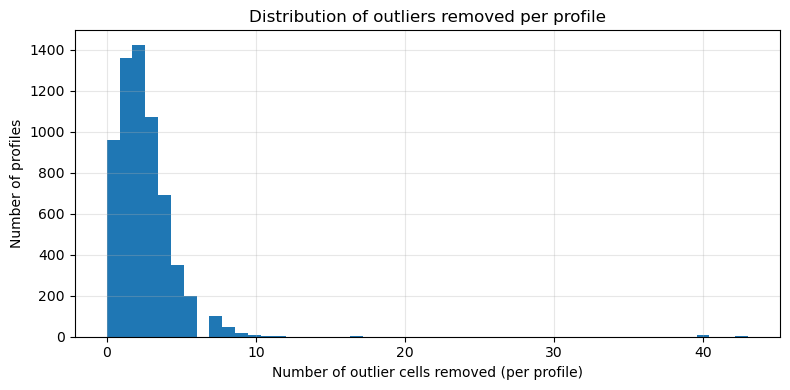

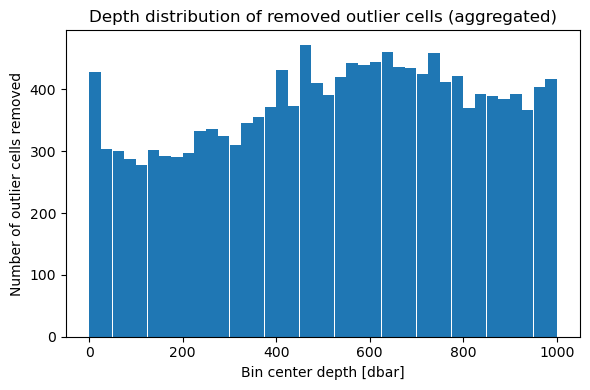

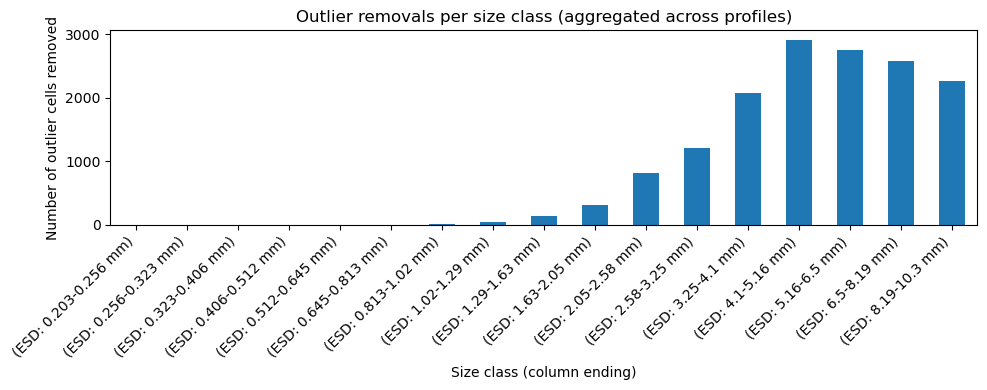

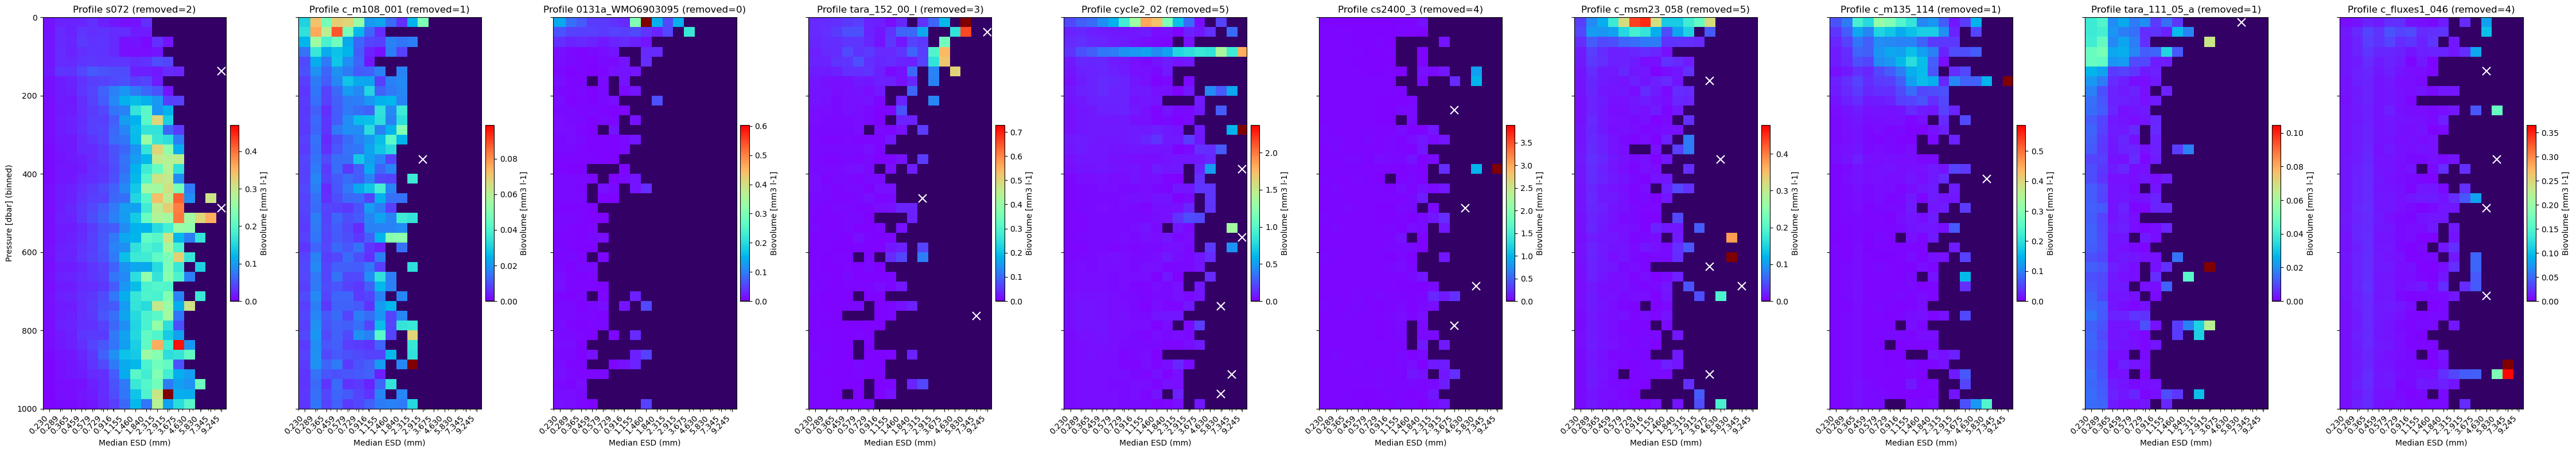

Done. Flagged 15141 BV cells across 5290 profiles.


In [17]:
#!/usr/bin/env python3
"""
Remove 2-D outliers from already-binned (25 dbar) Biovolume (BV) data using a
single MAD-based z-score computed on the whole profile (all selected size classes
and depths combined). Neighbor checks are performed in both size and depth
directions around each candidate outlier (configurable window). Outliers are
replaced by linear interpolation along depth (per size class). The script
produces diagnostics and plots:

- Histogram: number of outliers removed per profile
- Depth distribution of removals (counts per bin center)
- Distribution of removals per size class (bar plot)
- Example 1xN tile plots (BV tiles) with removed points marked; x-axis is log-scaled

Behavior & assumptions:
- You already have a DataFrame `grouped` in the workspace. It must contain:
    - 'Profile_id'
    - 'depth_bin' (integer)
    - 'bin_center_dbar' (e.g., 2.5, 7.5, 12.5, ...)
    - BV columns matching choose_column_prefix + manual_size_endings
- BV values are mean BV within each 5 dbar bin (as you stated).
- The script ignores runtime warnings that arise from operations on slices with many zeros/NaNs.
- Tunable parameters are at the top.

Outputs:
- cleaned_grouped: copy of grouped with outliers replaced (interpolated)
- bv_outlier_mask: boolean DataFrame True where outlier was flagged
- Several inline plots shown via plt.show()

Run this in the environment where `grouped` is already defined.
"""

import re
import random
import warnings
from typing import List, Tuple, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize

# ----------------- TUNABLE PARAMETERS -----------------
manual_size_endings = [
    #" (ESD: 0.102-0.128 mm)",
    #" (ESD: 0.128-0.161 mm)",
    #" (ESD: 0.161-0.203 mm)",
    " (ESD: 0.203-0.256 mm)",
    " (ESD: 0.256-0.323 mm)",
    " (ESD: 0.323-0.406 mm)",
    " (ESD: 0.406-0.512 mm)",
    " (ESD: 0.512-0.645 mm)",
    " (ESD: 0.645-0.813 mm)",
    " (ESD: 0.813-1.02 mm)",
    " (ESD: 1.02-1.29 mm)",
    " (ESD: 1.29-1.63 mm)",
    " (ESD: 1.63-2.05 mm)",
    " (ESD: 2.05-2.58 mm)",
    " (ESD: 2.58-3.25 mm)",
    " (ESD: 3.25-4.1 mm)",
    " (ESD: 4.1-5.16 mm)",
    " (ESD: 5.16-6.5 mm)",
    " (ESD: 6.5-8.19 mm)",
    " (ESD: 8.19-10.3 mm)",
    #" (ESD: 10.3-13 mm)",
    #" (ESD: 13-16.4 mm)",
    #" (ESD: 16.4-20.6 mm)",
]

choose_column_prefix = "Biovolume"   # columns to match
# MAD-based zscore threshold
mad_z_thresh = 4.0
# neighbor windows to check for supporting evidence (number of neighbors on each side)
neighbor_depth = 2   # check up/down depth bins (default 1 = immediate neighbors)
neighbor_size = 2    # check left/right size classes (default 1)
# If both neighbor checks fail (i.e., candidate is not isolated relative to neighbors),
# you may still remove if absolute MAD z >= extreme_thresh_factor * mad_z_thresh
extreme_thresh_factor = 100.0

random_seed = 42
n_example_profiles = 10

# plotting / axis settings
x_scale = "log"  # you requested log x-axis in final plots
plt.style.use("default")
# ignore runtime warnings (e.g., from nanmean/nanstd on empty slices)
warnings.filterwarnings("ignore", category=RuntimeWarning)
# ------------------------------------------------------

# build custom rainbow colormap (dark endpoints)
rainbow = plt.get_cmap("rainbow")
_colors = rainbow(np.linspace(0, 1, 256))
def _darken(rgb, factor=0.75):
    return np.clip(rgb * factor, 0, 1)
_colors[0, :3] = _darken(_colors[0, :3], factor=0.4)
_colors[-1, :3] = _darken(_colors[-1, :3], factor=0.5)
custom_rainbow = LinearSegmentedColormap.from_list("custom_rainbow", _colors)


def find_manual_columns(df: pd.DataFrame, prefix: str, endings: List[str]) -> List[str]:
    all_cols = list(df.columns)
    found = []
    for ending in endings:
        regex = re.compile(re.escape(ending) + r"$")
        candidates = [c for c in all_cols if regex.search(str(c)) and prefix in str(c)]
        if len(candidates) == 1:
            found.append(candidates[0])
        elif len(candidates) > 1:
            found.append(candidates[0])
            print(f"Warning: multiple columns matched ending '{ending}' and prefix '{prefix}'; using '{candidates[0]}'")
        else:
            exact = prefix + ending
            if exact in all_cols:
                found.append(exact)
            else:
                print(f"Warning: no column found for ending '{ending}' with prefix '{prefix}'; skipping this size.")
    if len(found) == 0:
        raise RuntimeError("No BV columns found. Check choose_column_prefix and manual_size_endings.")
    return found


def mad(arr: np.ndarray, axis=None) -> np.ndarray:
    """Median absolute deviation. Returns MAD (not scaled)."""
    arr = np.asarray(arr)
    med = np.nanmedian(arr, axis=axis)
    if axis is None:
        return np.nanmedian(np.abs(arr - med))
    else:
        # work with broadcasting
        med_expanded = np.expand_dims(med, axis=axis)
        return np.nanmedian(np.abs(arr - med_expanded), axis=axis)


def mad_zscore_flat(Z: np.ndarray) -> np.ndarray:
    """
    Compute MAD-based z-score on the flattened profile matrix Z (n_depths x n_sizes).
    Returns array of same shape with robust z-scores:
        z = (x - median_all) / (MAD_all * 1.4826)
    Where MAD_all is median absolute deviation across all valid (non-nan) entries in Z.
    If MAD_all == 0, we fallback to using std-based zscore where possible; if std==0 -> z=0.
    """
    flat = Z.ravel()
    valid = ~np.isnan(flat)
    if not np.any(valid):
        return np.zeros_like(Z)
    vals = flat[valid]
    med = np.median(vals)
    mad_val = np.median(np.abs(vals - med))
    if mad_val > 0:
        sigma = mad_val * 1.4826
        z_flat = np.full(flat.shape, np.nan, dtype=float)
        z_flat[valid] = (flat[valid] - med) / sigma
        z = z_flat.reshape(Z.shape)
        z = np.where(np.isnan(z), 0.0, z)
        return z
    else:
        # fallback to std-based
        mean = np.nanmean(flat)
        std = np.nanstd(flat, ddof=0)
        if std > 0:
            z_flat = np.full(flat.shape, np.nan, dtype=float)
            z_flat[valid] = (flat[valid] - mean) / std
            z = z_flat.reshape(Z.shape)
            z = np.where(np.isnan(z), 0.0, z)
            return z
        else:
            # no variation at all
            return np.zeros_like(Z)


def neighbors_have_support(Z: np.ndarray, i: int, j: int,
                           nd: int, ns: int) -> Tuple[bool, Dict[str, int]]:
    """
    Check neighbors around cell (i,j):
      - depth neighbors: rows i-nd ... i+nd excluding i
      - size neighbors: cols j-ns ... j+ns excluding j
    Returns (has_support, diagnostics) where has_support True if at least one neighbor
    in either direction has a non-zero (or non-nan) value comparable to the candidate.
    Diagnostics includes counts of valid neighbors examined.
    """
    n_depths, n_sizes = Z.shape
    # depth neighbor indices
    i0 = max(0, i - nd)
    i1 = min(n_depths - 1, i + nd)
    depth_idx = [k for k in range(i0, i1 + 1) if k != i]
    # size neighbor indices
    j0 = max(0, j - ns)
    j1 = min(n_sizes - 1, j + ns)
    size_idx = [k for k in range(j0, j1 + 1) if k != j]

    diag = {"depth_valid": 0, "size_valid": 0}
    val = Z[i, j]
    if np.isnan(val):
        return False, diag

    # Depth neighbors: check same size class at neighboring depths
    depth_vals = np.array([Z[k, j] for k in depth_idx]) if depth_idx else np.array([])
    depth_valid = np.sum(~np.isnan(depth_vals))
    diag["depth_valid"] = int(depth_valid)

    # Size neighbors: check same depth at neighboring sizes
    size_vals = np.array([Z[i, k] for k in size_idx]) if size_idx else np.array([])
    size_valid = np.sum(~np.isnan(size_vals))
    diag["size_valid"] = int(size_valid)

    # Define "support" as having at least one non-zero neighbor OR multiple small neighbors.
    # Use non-zero (strict) because zeros are common for large sizes and not considered support.
    depth_support = False
    if depth_vals.size > 0:
        depth_support = np.any((~np.isnan(depth_vals)) & (depth_vals > 0))
    size_support = False
    if size_vals.size > 0:
        size_support = np.any((~np.isnan(size_vals)) & (size_vals > 0))

    has_support = bool(depth_support or size_support)
    return has_support, diag


def interpolate_outliers_along_depth(df_prof: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    """
    Fill NaN values in df_prof[cols] by linear interpolation along depth (bin_center_dbar).
    Forward/backward fill at edges is also allowed (limit_direction='both').
    Returns a copy of df_prof with interpolated columns.
    """
    prof_sorted = df_prof.sort_values('bin_center_dbar').copy()
    for c in cols:
        ser = prof_sorted[c]
        if ser.isna().all():
            continue
        ser_interp = ser.interpolate(method='linear', limit_direction='both')
        prof_sorted[c] = ser_interp
    return prof_sorted


def run_mad_outlier_removal(grouped: pd.DataFrame,
                            prefix: str,
                            manual_endings: List[str],
                            mad_z_thresh: float = 4.0,
                            neighbor_depth: int = 1,
                            neighbor_size: int = 1,
                            extreme_thresh_factor: float = 2.0,
                            require_support: bool = True,
                            random_seed: int = 42,
                            n_example_profiles: int = 10,
                            x_scale: str = "log"):
    """
    Main routine. Returns cleaned_grouped, bv_outlier_mask, and per-profile summaries.
    """
    bv_cols = find_manual_columns(grouped, prefix, manual_endings)
    print(f"Processing BV columns: {len(bv_cols)} classes.")

    if 'Profile_id' not in grouped.columns or 'bin_center_dbar' not in grouped.columns:
        raise RuntimeError("`grouped` must contain 'Profile_id' and 'bin_center_dbar' columns.")

    cleaned = grouped.copy(deep=True)
    bv_mask = pd.DataFrame(False, index=cleaned.index, columns=bv_cols, dtype=bool)

    profile_ids = cleaned['Profile_id'].unique().tolist()
    per_profile_counts = {}
    per_profile_depth_counts = {}
    per_profile_size_counts = {c: 0 for c in bv_cols}

    # For reproducibility of example selection
    random.seed(random_seed)

    for p in profile_ids:
        prof_idx = cleaned['Profile_id'] == p
        prof_df = cleaned.loc[prof_idx].copy()
        if prof_df.shape[0] == 0:
            per_profile_counts[p] = 0
            continue

        # ensure sorted by depth
        prof_df = prof_df.sort_values('bin_center_dbar')
        idx = prof_df.index.to_numpy()
        Z = prof_df[bv_cols].to_numpy(dtype=float)  # n_depths x n_sizes

        if Z.size == 0 or np.all(np.isnan(Z)):
            per_profile_counts[p] = 0
            continue

        # compute flattened MAD zscore for the profile
        z = mad_zscore_flat(Z)

        # candidate outliers where abs(z) >= mad_z_thresh
        candidates = np.abs(z) >= mad_z_thresh

        # examine candidates: require lack of neighbor support (isolated) to keep as outlier,
        # but also allow extreme cases (>= extreme_thresh_factor*mad_z_thresh) to be flagged regardless
        extreme_candidates = np.abs(z) >= (extreme_thresh_factor * mad_z_thresh)
        outlier_flag = np.zeros_like(candidates, dtype=bool)

        n_depths, n_sizes = Z.shape
        for i in range(n_depths):
            for j in range(n_sizes):
                if not candidates[i, j] and not extreme_candidates[i, j]:
                    continue
                val = Z[i, j]
                if np.isnan(val):
                    continue

                has_support, diag = neighbors_have_support(Z, i, j, neighbor_depth, neighbor_size)

                # decide removal
                if extreme_candidates[i, j]:
                    # extreme: remove regardless of support
                    mark = True
                else:
                    # candidate: remove if NOT supported by neighbors OR if require_support is False
                    mark = (not has_support) or (not require_support)

                if mark:
                    outlier_flag[i, j] = True

        # apply mask and replacement (set NaN then interpolate)
        bv_mask.loc[idx, bv_cols] = outlier_flag
        # set flagged values to NaN in cleaned copy
        cleaned.loc[idx, bv_cols] = np.where(outlier_flag, np.nan, prof_df[bv_cols].to_numpy())

        # interpolate along depth per size class to fill removed points
        prof_cleaned = cleaned.loc[idx].sort_values('bin_center_dbar')
        prof_cleaned_interp = interpolate_outliers_along_depth(prof_cleaned, bv_cols)
        # write interpolated values back
        cleaned.loc[idx, bv_cols] = prof_cleaned_interp[bv_cols].to_numpy()

        # statistics
        total_flagged = int(outlier_flag.sum())
        per_profile_counts[p] = total_flagged
        bin_centers = prof_df['bin_center_dbar'].to_numpy()
        depth_counts = dict(zip(bin_centers, outlier_flag.sum(axis=1).astype(int)))
        per_profile_depth_counts[p] = depth_counts

        # size class counts
        for j, c in enumerate(bv_cols):
            per_profile_size_counts[c] += int(outlier_flag[:, j].sum())

    total_flagged_all = int(bv_mask.values.sum())
    n_profiles_with_flagged = int((pd.Series(per_profile_counts) > 0).sum())
    print(f"Flagged {total_flagged_all} BV cells across {n_profiles_with_flagged} profiles (out of {len(profile_ids)} profiles).")

    # --- PLOTS ---
    # 1) histogram: number of outliers removed per profile
    s_counts = pd.Series(per_profile_counts)
    plt.figure(figsize=(8, 4))
    s_counts.hist(bins=50)
    plt.xlabel("Number of outlier cells removed (per profile)")
    plt.ylabel("Number of profiles")
    plt.title("Distribution of outliers removed per profile")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 2) depth distribution of removals (aggregate across profiles)
    depth_counter = {}
    for p, dct in per_profile_depth_counts.items():
        for bc, cnt in dct.items():
            depth_counter[bc] = depth_counter.get(bc, 0) + int(cnt)
    if depth_counter:
        items = sorted(depth_counter.items(), key=lambda x: x[0])
        depths, counts = zip(*items)
        plt.figure(figsize=(6, 4))
        plt.bar(depths, counts, width=(max(depths) - min(depths)) / max(1, len(depths)), align='center')
        plt.xlabel("Bin center depth [dbar]")
        plt.ylabel("Number of outlier cells removed")
        plt.title("Depth distribution of removed outlier cells (aggregated)")
        plt.tight_layout()
        plt.show()
    else:
        print("No depth-binned outliers to plot.")

    # 3) distribution per size class
    size_counts = pd.Series(per_profile_size_counts)
    size_counts.index = [re.sub(r".*\(ESD:", "(ESD:", c) for c in size_counts.index]  # shorten labels
    plt.figure(figsize=(10, 4))
    size_counts.plot(kind='bar')
    plt.xlabel("Size class (column ending)")
    plt.ylabel("Number of outlier cells removed")
    plt.title("Outlier removals per size class (aggregated across profiles)")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # 4) example tile plots with removed outliers marked (1xN)
    available_profiles = profile_ids
    random.seed(random_seed)
    example_profiles = random.sample(available_profiles, min(n_example_profiles, len(available_profiles)))
    ncols = len(example_profiles)
    fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(4.5 * ncols, 8), squeeze=False)
    axes = axes[0]

    # Try to get median ESD for x positions
    def median_from_col(colname):
        m = re.search(r"ESD:\s*([0-9.>]+)\s*(?:-\s*([0-9.>]+))?\s*mm", colname)
        if not m:
            nums = re.findall(r"[\d.]+", colname)
            if len(nums) >= 2:
                return (float(nums[0]) + float(nums[1])) / 2.0
            if len(nums) == 1:
                return float(nums[0])
            return np.nan
        a = float(m.group(1).replace('>', '').replace('<', ''))
        b = m.group(2)
        if b:
            b = float(b)
            return (a + b) / 2.0
        return a

    x_meds = [median_from_col(c) for c in bv_cols]
    if all(np.isnan(x_meds)):
        x_vals = np.arange(len(bv_cols))
        x_tick_labels = [str(i) for i in range(len(bv_cols))]
    else:
        x_vals = np.array([xm if not np.isnan(xm) else i for i, xm in enumerate(x_meds)])
        x_tick_labels = [f"{v:.3f}" for v in x_vals]

    for ax, prof in zip(axes, example_profiles):
        prof_idx = cleaned['Profile_id'] == prof
        prof_df = cleaned.loc[prof_idx].sort_values('bin_center_dbar')
        orig_idx = grouped['Profile_id'] == prof
        orig_prof = grouped.loc[orig_idx].sort_values('bin_center_dbar')
        if prof_df.shape[0] == 0:
            ax.set_visible(False)
            continue

        pivot = prof_df.set_index('bin_center_dbar')[bv_cols]
        y_vals = pivot.index.to_numpy()
        Z = pivot.to_numpy(dtype=float)
        Z_plot = np.ma.masked_invalid(Z)

        # x and y edges
        if len(x_vals) == 1:
            x_edges = np.array([x_vals[0] - 0.5 * x_vals[0], x_vals[0] + 0.5 * x_vals[0]])
        else:
            mid = (x_vals[:-1] + x_vals[1:]) / 2.0
            x_edges = np.concatenate(([x_vals[0] - (mid[0] - x_vals[0])], mid, [x_vals[-1] + (x_vals[-1] - mid[-1])]))

        if len(y_vals) == 1:
            y_edges = np.array([y_vals[0] - 0.5 * y_vals[0], y_vals[0] + 0.5 * y_vals[0]])
        else:
            y_mid = (y_vals[:-1] + y_vals[1:]) / 2.0
            y_edges = np.concatenate(([y_vals[0] - (y_mid[0] - y_vals[0])], y_mid, [y_vals[-1] + (y_vals[-1] - y_mid[-1])]))

        panel_vmax = np.nanmax(Z_plot) if np.nanmax(Z_plot) > 0 else 1.0
        norm = Normalize(vmin=0.0, vmax=float(panel_vmax))

        try:
            mesh = ax.pcolormesh(x_edges, y_edges, Z_plot, cmap=custom_rainbow, norm=norm, shading='auto')
        except ValueError:
            extent = [x_edges[0], x_edges[-1], y_edges[-1], y_edges[0]]
            mesh = ax.imshow(Z_plot, aspect='auto', cmap=custom_rainbow, norm=norm, extent=extent, origin='upper')

        # overlay removed outliers
        mask_sub = bv_mask.loc[orig_prof.index, bv_cols] if not bv_mask.empty else None
        if mask_sub is not None and mask_sub.shape[0] == orig_prof.shape[0]:
            flagged = mask_sub.to_numpy()
            for yi, depth in enumerate(orig_prof['bin_center_dbar'].values):
                for xj, col in enumerate(bv_cols):
                    if flagged[yi, xj]:
                        ax.plot(x_vals[xj], depth, marker='x', color='white', markersize=10, mew=1.5)

        ax.invert_yaxis()
        # x-axis log scale if requested and x_vals positive
        if x_scale == "log" and np.all(x_vals > 0):
            ax.set_xscale("log")
        ax.set_xlabel("Median ESD (mm)")
        if ax is axes[0]:
            ax.set_ylabel("Pressure [dbar] (binned)")
        else:
            ax.set_yticklabels([])
        ax.set_title(f"Profile {prof} (removed={per_profile_counts.get(prof,0)})")

        # ticks
        if x_scale == "log" and np.all(x_vals > 0):
            ax.set_xticks(x_vals)
            ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
            ax.ticklabel_format(axis='x', style='plain')
            ax.set_xticklabels(x_tick_labels, rotation=45, ha='right')
        else:
            if len(x_vals) <= 10:
                ax.set_xticks(x_vals)
                ax.set_xticklabels(x_tick_labels, rotation=45, ha='right')
            else:
                step = max(1, len(x_vals) // 10)
                ticks = x_vals[::step]
                ticklabels = [x_tick_labels[i] for i in range(0, len(x_vals), step)]
                ax.set_xticks(ticks)
                ax.set_xticklabels(ticklabels, rotation=45, ha='right')

        cb = fig.colorbar(mesh, ax=ax, orientation='vertical', fraction=0.045, pad=0.02)
        cb.set_label("Biovolume [mm3 l-1]")

    # hide unused axes
    if len(example_profiles) < len(axes):
        for ax in axes[len(example_profiles):]:
            ax.set_visible(False)

    plt.tight_layout()
    plt.show()

    summaries = {
        "cleaned_grouped": cleaned,
        "bv_outlier_mask": bv_mask,
        "per_profile_counts": per_profile_counts,
        "per_profile_depth_counts": per_profile_depth_counts,
        "per_profile_size_counts": per_profile_size_counts,
    }
    return summaries


# ----------------- Execute when run as script -----------------
if __name__ == "__main__":
    try:
        grouped  # type: ignore
    except NameError:
        raise RuntimeError("Please load your 5 dbar-binned BV DataFrame into the variable `grouped` before running this script.")

    summaries = run_mad_outlier_removal(
        grouped=grouped,
        prefix=choose_column_prefix,
        manual_endings=manual_size_endings,
        mad_z_thresh=mad_z_thresh,
        neighbor_depth=neighbor_depth,
        neighbor_size=neighbor_size,
        extreme_thresh_factor=extreme_thresh_factor,
        require_support=True,
        random_seed=random_seed,
        n_example_profiles=n_example_profiles,
        x_scale=x_scale,
    )

    cleaned_grouped = summaries["cleaned_grouped"]
    bv_outlier_mask = summaries["bv_outlier_mask"]
    per_profile_counts = summaries["per_profile_counts"]
    per_profile_depth_counts = summaries["per_profile_depth_counts"]
    per_profile_size_counts = summaries["per_profile_size_counts"]

    total_flagged = int(bv_outlier_mask.values.sum())
    n_profiles_with_flagged = int((pd.Series(per_profile_counts) > 0).sum())
    print(f"Done. Flagged {total_flagged} BV cells across {n_profiles_with_flagged} profiles.")

# Remove profiles with all NaN in core size classes

In [18]:
#!/usr/bin/env python3
"""
Find profiles that have ONLY NaN (not zeros) in any Biovolume size-class column
across all depths, report how many such profiles there are, and optionally remove
them from the DataFrame.

This version checks ALL Biovolume columns automatically (no need to specify one).
Behavior:
 - For each Biovolume column, find profiles where every depth bin for that profile
   is NaN in that column (i.e. no non-NaN anywhere for that profile in that column).
 - Collect the union of profiles that are entirely-NaN for at least one Biovolume column.
 - Report counts and sample IDs, and optionally remove those profiles from the DataFrame.

Assumptions:
 - Your DataFrame is available as `filtered_cleaned_grouped` in the workspace.
 - It contains 'Profile_id' and Biovolume columns whose names include "Biovolume".
 - NaN is treated as missing; zeros are treated as valid values.

Outputs:
 - removed_profiles_unique_all_nan_any_bv : list of removed profile ids (saved to globals)
 - filtered_filtered_cleaned_grouped      : filtered dataframe (saved to globals) if drop_profiles=True
"""

import re
from typing import List, Dict
import numpy as np
import pandas as pd

# -------- USER TUNABLES ----------
input_df_name = "cleaned_grouped"  # name of DataFrame in globals()
drop_profiles = True                        # remove identified profiles if True
overwrite_input_variable = False            # overwrite original variable if True
n_sample_report = 30                        # sample size to print
# ---------------------------------

# Load DataFrame
try:
    df = globals()[input_df_name]
except KeyError:
    raise RuntimeError(f"DataFrame named '{input_df_name}' not found in globals(). Please load it or change input_df_name.")

# Detect all Biovolume columns automatically
bv_cols = [c for c in df.columns if "Biovolume" in str(c)]
if len(bv_cols) == 0:
    raise RuntimeError("No Biovolume columns found in the DataFrame. Ensure columns contain the substring 'Biovolume' or adjust detection logic.")

print(f"Detected {len(bv_cols)} Biovolume columns to check.")

# For each BV column, find profiles that have ONLY NaN across all depths for that column
profile_col = "Profile_id"
if profile_col not in df.columns:
    raise RuntimeError(f"'{profile_col}' column not found in DataFrame; required to group by profile.")

removed_profiles_per_col: Dict[str, List[str]] = {}
for col in bv_cols:
    # For each profile: check if any row has a non-NaN (i.e. profile has any valid value)
    profile_has_any = df.groupby(profile_col)[col].apply(lambda s: s.notna().any())
    profiles_only_nan = profile_has_any[~profile_has_any].index.tolist()
    removed_profiles_per_col[col] = profiles_only_nan
    print(f"Column '{col}': profiles with ONLY NaN = {len(profiles_only_nan)}")

# Union of all profiles that are empty in at least one BV column
all_removed_profiles = sorted({pid for lst in removed_profiles_per_col.values() for pid in lst})
n_total_profiles = df[profile_col].nunique()
n_removed = len(all_removed_profiles)
print()
print(f"Total unique profiles: {n_total_profiles}")
print(f"Profiles that are ALL-NaN in at least one Biovolume column: {n_removed}")
if n_removed > 0:
    print(f"Sample of up to {n_sample_report} such profile IDs:")
    for pid in all_removed_profiles[:n_sample_report]:
        print("  ", pid)

# Optionally remove these profiles
if drop_profiles and n_removed > 0:
    df_filtered = df[~df[profile_col].isin(all_removed_profiles)].copy()
    print(f"\nFiltered DataFrame shape: before={df.shape}, after={df_filtered.shape} (removed {n_removed} profiles).")
    # Save results to globals for convenience
    globals()["removed_profiles_unique_all_nan_any_bv"] = all_removed_profiles
    globals()["removed_profiles_per_bv_col"] = removed_profiles_per_col
    globals()["filtered_filtered_cleaned_grouped"] = df_filtered
    if overwrite_input_variable:
        globals()[input_df_name] = df_filtered
        print(f"Overwrote variable '{input_df_name}' in globals() with the filtered DataFrame.")
else:
    # no removal requested or nothing to remove; save results nonetheless
    globals()["removed_profiles_unique_all_nan_any_bv"] = all_removed_profiles
    globals()["removed_profiles_per_bv_col"] = removed_profiles_per_col
    print("\nNo profiles removed (drop_profiles=False or no profiles found). Results saved to globals for inspection.")

# Report summary dict
report = {
    "input_df": input_df_name,
    "n_bv_columns_checked": len(bv_cols),
    "total_profiles": int(n_total_profiles),
    "profiles_marked_for_removal": int(n_removed),
    "removed_profiles_variable": "removed_profiles_unique_all_nan_any_bv",
    "removed_per_column_variable": "removed_profiles_per_bv_col",
    "filtered_dataframe_variable": "filtered_cleaned_grouped" if (drop_profiles and n_removed>0) else None
}
print("\nReport:")
for k, v in report.items():
    print(f"  {k}: {v}")

# Return filtered df in globals for interactive use (if not removing, return original)
if drop_profiles and n_removed > 0:
    globals()["filtered_cleaned_grouped_after_removal"] = df_filtered
else:
    globals()["filtered_cleaned_grouped_after_removal"] = df.copy()

Detected 17 Biovolume columns to check.
Column 'Biovolume [ppm] (ESD: 0.203-0.256 mm)': profiles with ONLY NaN = 0
Column 'Biovolume [ppm] (ESD: 0.256-0.323 mm)': profiles with ONLY NaN = 0
Column 'Biovolume [ppm] (ESD: 0.323-0.406 mm)': profiles with ONLY NaN = 0
Column 'Biovolume [ppm] (ESD: 0.406-0.512 mm)': profiles with ONLY NaN = 0
Column 'Biovolume [ppm] (ESD: 0.512-0.645 mm)': profiles with ONLY NaN = 0
Column 'Biovolume [ppm] (ESD: 0.645-0.813 mm)': profiles with ONLY NaN = 0
Column 'Biovolume [ppm] (ESD: 0.813-1.02 mm)': profiles with ONLY NaN = 0
Column 'Biovolume [ppm] (ESD: 1.02-1.29 mm)': profiles with ONLY NaN = 0
Column 'Biovolume [ppm] (ESD: 1.29-1.63 mm)': profiles with ONLY NaN = 0
Column 'Biovolume [ppm] (ESD: 1.63-2.05 mm)': profiles with ONLY NaN = 0
Column 'Biovolume [ppm] (ESD: 2.05-2.58 mm)': profiles with ONLY NaN = 0
Column 'Biovolume [ppm] (ESD: 2.58-3.25 mm)': profiles with ONLY NaN = 347
Column 'Biovolume [ppm] (ESD: 3.25-4.1 mm)': profiles with ONLY NaN =

In [19]:
# are there any NaN values left in the columns starting with Biovolume?
df = filtered_cleaned_grouped_after_removal.copy()

bv_cols_with_nan = [c for c in df.columns if "Biovolume" in str(c) and df[c].isna().any()]
if bv_cols_with_nan:
    print("\nWarning: The following Biovolume columns still contain NaN values after removal:")
    for c in bv_cols_with_nan:
        n_nan = df[c].isna().sum()
        print(f"  Column '{c}': {n_nan} NaN values")

# Save Profile_ids with NaN in any Biovolume column
profiles_with_nan_any_bv = df[df[bv_cols_with_nan].isna().any(axis=1)]['Profile_id'].unique().tolist()
globals()["profiles_with_nan_any_bv"] = profiles_with_nan_any_bv
# print how many such profiles there are
print(f"\nNumber of profiles with NaN in any Biovolume column: {len(profiles_with_nan_any_bv)}")
# remove these profiles from df
if len(profiles_with_nan_any_bv) > 0:
    df = df[~df['Profile_id'].isin(profiles_with_nan_any_bv)].copy()
    print(f"Filtered DataFrame shape after removing profiles with NaN in any Biovolume column: {df.shape}")

df_filtered_cleaned_grouped = df.copy()

# check again if there are any NaN values left in Biovolume columns
bv_cols_with_nan_after = [c for c in df_filtered_cleaned_grouped.columns if "Biovolume" in str(c) and df_filtered_cleaned_grouped[c].isna().any()]
if bv_cols_with_nan_after:
    print("\nWarning: After final filtering, the following Biovolume columns still contain NaN values:")
    for c in bv_cols_with_nan_after:
        n_nan = df_filtered_cleaned_grouped[c].isna().sum()
        print(f"  Column '{c}': {n_nan} NaN values")

# number of profiles remaining in df_filtered_cleaned_grouped
n_profiles_remaining = df_filtered_cleaned_grouped['Profile_id'].nunique()
print(f"\nNumber of profiles remaining after all filtering: {n_profiles_remaining}")


Number of profiles with NaN in any Biovolume column: 0

Number of profiles remaining after all filtering: 5894


### Remove any profiles which do not have 40 depth bins

In [21]:
#!/usr/bin/env python3
"""
Remove profiles that have fewer than 40 depth bins and plot how many were removed.

Usage:
 - Put your DataFrame in the global variable named by `input_df_name` (default:
   "filtered_cleaned_grouped"). Change the name if your variable is different.
 - Run this script in the same Python session (notebook or script). It will:
     * compute the count of unique depth bins per Profile_id
     * identify profiles with count < 40
     * remove those profiles and return a filtered DataFrame
     * plot a small summary: bar (removed vs kept) and histogram of counts per profile
 - The filtered DataFrame is saved into globals() as `filtered_40depths_df`.
 - The list of removed Profile_id values is saved to globals() as `removed_profiles_lt_40`.

Adjust parameters below if you want a different cutoff or variable name.
"""

from typing import List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------- TUNABLES -----------------
df = df_filtered_cleaned_grouped
profile_col = "Profile_id"
depth_index_col = "bin_center_dbar"               # column to count unique depth levels (could use 'bin_center_dbar' instead)
min_depth_levels = 40                       # profiles with fewer than this will be removed
save_to_globals = True                      # save results back to globals()
plot_figsize = (10, 4)
# -------------------------------------------

# Count unique depth bins per profile
depth_counts = df.groupby(profile_col)[depth_index_col].nunique().sort_values()

# Identify profiles to remove (fewer than min_depth_levels)
profiles_to_remove = depth_counts[depth_counts < min_depth_levels].index.tolist()
n_profiles_total = depth_counts.shape[0]
n_profiles_remove = len(profiles_to_remove)
n_profiles_keep = n_profiles_total - n_profiles_remove

print(f"Total profiles: {n_profiles_total}")
print(f"Profiles with fewer than {min_depth_levels} depth bins (to remove): {n_profiles_remove}")
if n_profiles_remove > 0:
    print(profiles_to_remove[:20])

# Create filtered DataFrame (drop those profiles)
filtered_df = df[~df[profile_col].isin(profiles_to_remove)].copy()

# Save outputs to globals
if save_to_globals:
    globals()["filtered_40depths_df"] = filtered_df

# Return filtered dataframe for interactive use
filtered_df.info()
print(f"Filtered DataFrame has {filtered_df[profile_col].nunique()} profiles.")

# save cleaned data
filtered_df.to_pickle("../../Data/BV_1000_max_25_bins_outliers_removed_cleaned.pkl")

Total profiles: 5894
Profiles with fewer than 40 depth bins (to remove): 198
['c_msm049_009', '070_1', 'perle2_042', 'perle2_041', 'c_msm080_056', 'Yo_0213a_SEA087_m46', 'Yo_0382a_SEA087_m46', 'leg2st022', 'c_msm080_058', 'c_msm080_060', 'c_msm080_010', 'c_msm080_054', 'moose2018geleg2052', 'moose2013_ge_leg5_004', 'moose2013_ge_leg5_003', 'stn53_cast15', 'c_msm080_057', 'c_msm080_053', 'ctd057_1', 'moose110']
<class 'pandas.core.frame.DataFrame'>
Index: 227840 entries, 0 to 249575
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Profile_id                             227840 non-null  object 
 1   depth_bin                              227840 non-null  int64  
 2   Biovolume [ppm] (ESD: 0.203-0.256 mm)  227840 non-null  float64
 3   Biovolume [ppm] (ESD: 0.256-0.323 mm)  227840 non-null  float64
 4   Biovolume [ppm] (ESD: 0.323-0.406 mm)  227840 non-null  float

# Create Metadata file

In [22]:
import pandas as pd
metadata = pd.read_pickle('../../Data/Ecopart_data_merged_2008_2025_filtered.pkl')
profiles = pd.read_pickle('../../Data/BV_1000_max_25_bins_outliers_removed_cleaned.pkl')['Profile_id']

metadata['Profile_id'] = metadata['Profile_id'].astype(str)
profiles = profiles.astype(str)
meta_filtered =  metadata[metadata['Profile_id'].isin(profiles)]

# Verify
print(f"Unique Profile_ids: {meta_filtered['Profile_id'].nunique()}")

Unique Profile_ids: 5696


In [23]:
# save columns of interest as list
columns_to_save = ['Profile_id', 
                   'Latitude', 
                   'Longitude',
                   'datetime',]
meta_filtered_no_duplicates = meta_filtered[columns_to_save].drop_duplicates(['Profile_id', 'Latitude', 'Longitude','datetime']).reset_index(drop=True)
#metadata.info()

print(f"Number of rows in metadata: {meta_filtered_no_duplicates.shape[0]}")
# should be 5696

# save profile metadata
meta_filtered_no_duplicates.to_pickle('../../Data/Profile_metadata_BV_1000_max_25_bins.pkl')
print("Saved profile metadata to ../../Data/Profile_metadata_BV_1000_max_25_bins.pkl")

Number of rows in metadata: 5696
Saved profile metadata to ../../Data/Profile_metadata_BV_1000_max_25_bins.pkl


# Merge environmental data to Profile_ids
- Data sources: CopernicusMarine Services
    - https://data.marine.copernicus.eu/product/GLOBAL_MULTIYEAR_BGC_001_029/description
    - https://data.marine.copernicus.eu/product/GLOBAL_MULTIYEAR_PHY_ENS_001_031/description
    - Downloaded Copernicus files (total > 300 GB, then ran this script)
- for each Profile_id Latitude, Longitude, datetime & for the depth grid: 12.5 - 1000, 25 m depth bins
- Depth levels of Copernicus variables (logarithmic, 0-2000 m):
    -  [   0.5058    1.5559    2.6677    3.8563    5.1404    6.543     8.0925
    9.8228   11.7737   13.991    16.5253   19.4298   22.7576   26.5583
   30.8746   35.7402   41.18     47.2119   53.8506   61.1128   69.0217
   77.6112   86.9294   97.0413  108.0303  120.      133.0758  147.4062
  163.1645  180.5499  199.79    221.1412  244.8906  271.3564  300.8875
  333.8628  370.6885  411.7939  457.6256  508.6399  565.2923  628.026
  697.2587  773.3683  856.679   947.4479 1045.8542 1151.9912 1265.8615 1387.377  1516.3636 1652.5685 1795.6708 1945.2955]

1) create one NetCDF file with all profiles (UVP5 and Copernicus variable profiles) mapped to the same location and time coordinates
    - needs to extract data from large Cpernicus data files
    - different depth levels (profiles = 25 m depth bins, env. data = log scale bins)
2) interpolate the environmental variables to the same depth-increments as the UVP data
    - uses the created NetCDF file from step 1
3) save the .pkl file

In [ ]:
import pandas as pd

# Load metadata
metadata = pd.read_pickle('../../Data/Profile_metadata_BV_1000_max_25_bins.pkl')

print(f"Number of unique Profile_ids: {metadata['Profile_id'].nunique()}") # 5696
print(f"Number of unique Profile_ids (as strings): {metadata['Profile_id'].astype(str).nunique()}") # 5696
print(f"Number of unique Latitude x Longitude x datetime combinations: {metadata[['Latitude', 'Longitude', 'datetime']].drop_duplicates().shape[0]}") # 5696

Number of unique Profile_ids: 5696
Number of unique Profile_ids (as strings): 5696
Number of unique Latitude x Longitude x datetime combinations: 5696


## 1) create large NetCDF file

In [31]:
import xarray as xr
import numpy as np
import pandas as pd
from datetime import datetime
import os
import gc
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

class EnvironmentalProfileExtractor:
    """
    Extract complete environmental vertical profiles for each Profile_id
    from Copernicus Marine data files
    """
    
    def __init__(self, df_metadata, copernicus_folder, output_dir):
        """
        Initialize extractor
        
        Parameters:
        -----------
        df_metadata : pd.DataFrame
            DataFrame with columns: Profile_id, Latitude, Longitude, datetime
        copernicus_folder : str
            Path to Copernicus Marine data files
        output_dir : str
            Output directory for NetCDF file
        """
        self.df_metadata = df_metadata.copy()
        self.copernicus_folder = copernicus_folder
        self.output_dir = output_dir
        
        # Environmental variables to extract
        self.env_vars = ['ph', 'chl', 'no3', 'po4', 'si', 'o2', 'fe', 'phyc', 'thetao_mean', 'so_mean']
        
        os.makedirs(output_dir, exist_ok=True)
        
        # Ensure datetime column is in datetime format
        if 'datetime' not in self.df_metadata.columns:
            raise ValueError("DataFrame must contain 'datetime' column")
        
        self.df_metadata['datetime'] = pd.to_datetime(self.df_metadata['datetime'])
        
        # Convert Profile_id to string to avoid mixed type issues
        self.df_metadata['Profile_id'] = self.df_metadata['Profile_id'].astype(str)
        
        # Store extraction diagnostics
        self.diagnostics = {
            'failed_profiles': [],
            'partial_profiles': []
        }
        
        print(f"✅ Initialized with {len(self.df_metadata)} profiles")
        print(f"🌊 Environmental variables to extract: {len(self.env_vars)}")
    
    def _find_available_files(self, var):
        """Find available NetCDF files for a variable"""
        files_to_try = [
            os.path.join(self.copernicus_folder, f'{var}_2008-2017_copernicusmarine_depth_filter.nc'),
            os.path.join(self.copernicus_folder, f'{var}_2018-2025_copernicusmarine_depth_filter.nc')
        ]
        
        available_datasets = {}
        for file_path in files_to_try:
            if os.path.exists(file_path):
                try:
                    with xr.open_dataset(file_path) as ds_temp:
                        if var in ds_temp.variables:
                            time_start = pd.to_datetime(ds_temp.time.min().values)
                            time_end = pd.to_datetime(ds_temp.time.max().values)
                            available_datasets[file_path] = (time_start, time_end)
                except Exception as e:
                    print(f"⚠️  Warning: Could not open {os.path.basename(file_path)}: {e}")
        
        return available_datasets
    
    def _select_file_for_time(self, available_datasets, target_time):
        """Select the appropriate file based on target time"""
        # First, try exact time range match
        for file_path, (start_time, end_time) in available_datasets.items():
            if start_time <= target_time <= end_time:
                return file_path
        
        # If no exact match, find the closest file
        if available_datasets:
            closest_file = None
            min_distance = float('inf')
            
            for file_path, (start_time, end_time) in available_datasets.items():
                # Calculate distance to the nearest boundary
                if target_time < start_time:
                    distance = (start_time - target_time).total_seconds()
                elif target_time > end_time:
                    distance = (target_time - end_time).total_seconds()
                else:
                    distance = 0
                
                if distance < min_distance:
                    min_distance = distance
                    closest_file = file_path
            
            return closest_file
        
        return None
    
    def _get_depth_structure(self):
        """
        Determine the depth structure from Copernicus files
        """
        print("\n🔍 Determining depth structure from Copernicus files...")
        
        depth_levels = None
        
        for var in self.env_vars:
            available_datasets = self._find_available_files(var)
            if available_datasets:
                file_path = list(available_datasets.keys())[0]
                try:
                    with xr.open_dataset(file_path) as ds:
                        if 'depth' in ds.coords:
                            depth_levels = ds.depth.values
                            print(f"   Found depth structure from {var}: {len(depth_levels)} levels")
                            print(f"   Range: {depth_levels.min():.1f}m - {depth_levels.max():.1f}m")
                            break
                except Exception as e:
                    continue
        
        if depth_levels is None:
            raise ValueError("Could not determine depth structure from any data file")
        
        return depth_levels
    
    def _check_temporal_coverage(self):
        """Check temporal coverage of metadata vs available data"""
        print("\n📅 Checking temporal coverage...")
        
        meta_start = self.df_metadata['datetime'].min()
        meta_end = self.df_metadata['datetime'].max()
        
        print(f"   Metadata time range: {meta_start.strftime('%Y-%m-%d')} to {meta_end.strftime('%Y-%m-%d')}")
        
        # Check first variable for data coverage
        var = self.env_vars[0]
        available_datasets = self._find_available_files(var)
        
        if available_datasets:
            all_start = min([start for _, (start, end) in available_datasets.items()])
            all_end = max([end for _, (start, end) in available_datasets.items()])
            print(f"   Data time range ({var}): {all_start.strftime('%Y-%m-%d')} to {all_end.strftime('%Y-%m-%d')}")
            
            # Check for profiles outside data range
            outside_range = self.df_metadata[
                (self.df_metadata['datetime'] < all_start) | 
                (self.df_metadata['datetime'] > all_end)
            ]
            
            if len(outside_range) > 0:
                print(f"   ⚠️  {len(outside_range)} profiles outside data time range")
                print(f"       These will use nearest available time")
    
    def extract_environmental_profiles(self):
        """
        Extract complete environmental profiles for all Profile_ids
        
        Returns:
        --------
        xr.Dataset : Complete dataset with all environmental profiles
        """
        print("\n🌊 EXTRACTING ENVIRONMENTAL PROFILES")
        print("=" * 70)
        
        # Check temporal coverage
        self._check_temporal_coverage()
        
        # Get depth structure from Copernicus files
        depth_levels = self._get_depth_structure()
        
        n_profiles = len(self.df_metadata)
        n_depths = len(depth_levels)
        n_vars = len(self.env_vars)
        
        # Pre-allocate arrays
        print(f"\n🏗️  Allocating arrays...")
        print(f"   Shape: ({n_profiles} profiles, {n_depths} depths, {n_vars} variables)")
        
        # Initialize data arrays for environmental variables
        env_data = {}
        for var in self.env_vars:
            env_data[var] = np.full((n_profiles, n_depths), np.nan, dtype=np.float32)
        
        # Extract coordinate arrays from metadata (ensure Profile_id is string)
        profile_ids = self.df_metadata['Profile_id'].astype(str).values
        latitudes = self.df_metadata['Latitude'].values
        longitudes = self.df_metadata['Longitude'].values
        datetimes = self.df_metadata['datetime'].values
        
        # Process each environmental variable
        for var_idx, var in enumerate(self.env_vars):
            print(f"\n{'='*70}")
            print(f"🌡️  PROCESSING VARIABLE {var_idx + 1}/{n_vars}: {var}")
            print(f"{'='*70}")
            
            # Find available files for this variable
            available_datasets = self._find_available_files(var)
            
            if not available_datasets:
                print(f"❌ No data files found for {var}")
                continue
            
            print(f"✅ Found {len(available_datasets)} data file(s):")
            for file_path, (start, end) in available_datasets.items():
                print(f"   📂 {os.path.basename(file_path)} ({start.year}-{end.year})")
            
            # Extract profiles for each Profile_id
            success_count = 0
            fail_count = 0
            partial_count = 0
            
            # Keep track of open datasets to avoid reopening
            open_datasets = {}
            
            with tqdm(total=n_profiles, desc=f"Extracting {var}", unit="profile") as pbar:
                for i in range(n_profiles):
                    lat = latitudes[i]
                    lon = longitudes[i]
                    time = pd.to_datetime(datetimes[i])
                    profile_id = profile_ids[i]
                    
                    # Select appropriate file
                    file_to_use = self._select_file_for_time(available_datasets, time)
                    
                    if file_to_use is None:
                        if var_idx == 0:  # Only record once
                            self.diagnostics['failed_profiles'].append({
                                'Profile_id': profile_id,
                                'reason': 'No suitable file found',
                                'datetime': time
                            })
                        fail_count += 1
                        pbar.update(1)
                        continue
                    
                    # Open dataset if not already open
                    if file_to_use not in open_datasets:
                        try:
                            open_datasets[file_to_use] = xr.open_dataset(file_to_use)
                        except Exception as e:
                            print(f"\n❌ Error opening {os.path.basename(file_to_use)}: {e}")
                            fail_count += 1
                            pbar.update(1)
                            continue
                    
                    ds = open_datasets[file_to_use]
                    
                    # Extract profile at this location and time
                    try:
                        profile_data = ds[var].sel(
                            longitude=lon,
                            latitude=lat,
                            time=time,
                            method='nearest'
                        )
                        
                        # Store the values directly (all depths)
                        env_data[var][i, :] = profile_data.values
                        
                        # Check extraction success
                        n_valid = np.sum(~np.isnan(profile_data.values))
                        if n_valid == n_depths:
                            success_count += 1
                        elif n_valid > 0:
                            partial_count += 1
                            if var_idx == 0:  # Only record once
                                self.diagnostics['partial_profiles'].append({
                                    'Profile_id': profile_id,
                                    'valid_depths': n_valid,
                                    'total_depths': n_depths,
                                    'coverage': f"{n_valid/n_depths*100:.1f}%"
                                })
                        else:
                            fail_count += 1
                            if var_idx == 0:  # Only record once
                                self.diagnostics['failed_profiles'].append({
                                    'Profile_id': profile_id,
                                    'reason': 'All values NaN',
                                    'lat': lat,
                                    'lon': lon,
                                    'datetime': time
                                })
                            
                    except Exception as e:
                        fail_count += 1
                        if var_idx == 0:  # Only record once
                            self.diagnostics['failed_profiles'].append({
                                'Profile_id': profile_id,
                                'reason': f'Exception: {str(e)}',
                                'lat': lat,
                                'lon': lon,
                                'datetime': time
                            })
                    
                    # Update progress bar
                    pbar.set_postfix({
                        'Full': success_count,
                        'Partial': partial_count,
                        'Failed': fail_count
                    })
                    pbar.update(1)
            
            # Close open datasets
            for ds in open_datasets.values():
                ds.close()
            
            total_success = success_count + partial_count
            print(f"✅ {var}: {total_success:,}/{n_profiles:,} profiles extracted ({total_success/n_profiles*100:.1f}%)")
            print(f"   Full profiles: {success_count:,}, Partial profiles: {partial_count:,}, Failed: {fail_count:,}")
            
            # Clean up memory
            gc.collect()
        
        # Save diagnostics
        self._save_diagnostics()
        
        # Create xarray Dataset
        print(f"\n{'='*70}")
        print("📦 CREATING NETCDF DATASET")
        print(f"{'='*70}")
        
        # Create coordinates
        coords = {
            'profile': ('profile', range(n_profiles)),
            'depth': ('depth', depth_levels),
            'Profile_id': ('profile', profile_ids),  # Already converted to string
            'latitude': ('profile', latitudes),
            'longitude': ('profile', longitudes),
            'time': ('profile', datetimes)
        }
        
        # Create data variables
        data_vars = {}
        for var in self.env_vars:
            data_vars[var] = (['profile', 'depth'], env_data[var])
        
        # Create Dataset
        ds = xr.Dataset(data_vars, coords=coords)
        
        # Add global attributes
        ds.attrs = {
            'title': 'Environmental Vertical Profiles',
            'description': 'Environmental depth profiles extracted from Copernicus Marine Service for each profile location',
            'created': datetime.now().isoformat(),
            'created_by': 'bthobor',
            'source': 'Copernicus Marine Service',
            'depth_levels': str(n_depths),
            'depth_range': f'{depth_levels.min():.1f}-{depth_levels.max():.1f}m',
            'n_profiles': str(n_profiles),
            'variables': ', '.join(self.env_vars),
            'conventions': 'CF-1.8',
            'history': f'{datetime.now().isoformat()} - Extracted environmental profiles from Copernicus Marine data'
        }
        
        # Add variable attributes (WITHOUT _FillValue - it goes in encoding instead)
        var_long_names = {
            'ph': 'pH',
            'chl': 'Chlorophyll concentration',
            'no3': 'Nitrate concentration',
            'po4': 'Phosphate concentration',
            'si': 'Silicate concentration',
            'o2': 'Dissolved oxygen concentration',
            'fe': 'Iron concentration',
            'phyc': 'Phytoplankton carbon biomass',
            'thetao_mean': 'Mean potential temperature',
            'so_mean': 'Mean salinity'
        }
        
        var_units = {
            'ph': 'pH units',
            'chl': 'mg m-3',
            'no3': 'mmol m-3',
            'po4': 'mmol m-3',
            'si': 'mmol m-3',
            'o2': 'mmol m-3',
            'fe': 'mmol m-3',
            'phyc': 'mg m-3',
            'thetao_mean': 'degrees Celsius',
            'so_mean': 'PSU'
        }
        
        for var in self.env_vars:
            if var in ds.data_vars:
                ds[var].attrs = {
                    'long_name': var_long_names.get(var, var),
                    'units': var_units.get(var, 'unknown'),
                    'standard_name': var
                }
        
        # Add coordinate attributes
        ds['Profile_id'].attrs = {
            'long_name': 'Profile identifier',
            'description': 'Unique identifier for each vertical profile'
        }
        
        ds['latitude'].attrs = {
            'long_name': 'Latitude',
            'units': 'degrees_north',
            'standard_name': 'latitude'
        }
        
        ds['longitude'].attrs = {
            'long_name': 'Longitude',
            'units': 'degrees_east',
            'standard_name': 'longitude'
        }
        
        ds['time'].attrs = {
            'long_name': 'Time',
            'standard_name': 'time',
            'description': 'Date and time of profile measurement'
        }
        
        ds['depth'].attrs = {
            'long_name': 'Depth',
            'units': 'meters',
            'standard_name': 'depth',
            'positive': 'down',
            'axis': 'Z',
            'description': 'Depth levels from Copernicus Marine data'
        }
        
        print(f"✅ Dataset created successfully")
        print(f"   Dimensions: {dict(ds.dims)}")
        print(f"   Coordinates: {list(ds.coords.keys())}")
        print(f"   Data variables: {list(ds.data_vars.keys())}")
        
        return ds
    
    def _save_diagnostics(self):
        """Save extraction diagnostics"""
        diagnostics_path = os.path.join(self.output_dir, 'extraction_diagnostics.txt')
        
        with open(diagnostics_path, 'w') as f:
            f.write("EXTRACTION DIAGNOSTICS\n")
            f.write("=" * 70 + "\n\n")
            f.write(f"Created: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')} UTC\n\n")
            
            f.write(f"FAILED PROFILES: {len(self.diagnostics['failed_profiles'])}\n")
            f.write("-" * 70 + "\n")
            for item in self.diagnostics['failed_profiles'][:20]:  # Show first 20
                f.write(f"  Profile_id: {item['Profile_id']}\n")
                f.write(f"  Reason: {item['reason']}\n")
                if 'lat' in item:
                    f.write(f"  Location: ({item['lat']:.4f}, {item['lon']:.4f})\n")
                if 'datetime' in item:
                    f.write(f"  DateTime: {item['datetime']}\n")
                f.write("\n")
            
            if len(self.diagnostics['failed_profiles']) > 20:
                f.write(f"  ... and {len(self.diagnostics['failed_profiles']) - 20} more\n\n")
            
            f.write(f"\nPARTIAL PROFILES: {len(self.diagnostics['partial_profiles'])}\n")
            f.write("-" * 70 + "\n")
            for item in self.diagnostics['partial_profiles'][:20]:  # Show first 20
                f.write(f"  Profile_id: {item['Profile_id']}\n")
                f.write(f"  Coverage: {item['coverage']} ({item['valid_depths']}/{item['total_depths']} depths)\n\n")
            
            if len(self.diagnostics['partial_profiles']) > 20:
                f.write(f"  ... and {len(self.diagnostics['partial_profiles']) - 20} more\n")
        
        print(f"📋 Diagnostics saved: {diagnostics_path}")
    
    def save_to_netcdf(self, ds, filename='environmental_profiles.nc'):
        """Save dataset to NetCDF file with compression"""
        output_path = os.path.join(self.output_dir, filename)
        
        print(f"\n💾 SAVING TO NETCDF")
        print(f"{'='*70}")
        print(f"📁 Output: {output_path}")
        
        # Define compression settings (_FillValue goes here, not in attrs)
        encoding = {}
        for var in ds.data_vars:
            encoding[var] = {
                'zlib': True,
                'complevel': 4,
                'dtype': 'float32',
                '_FillValue': np.nan
            }
        
        # Save to NetCDF
        print("⏳ Writing to disk...")
        ds.to_netcdf(output_path, encoding=encoding, format='NETCDF4')
        
        # Get file size
        file_size_mb = os.path.getsize(output_path) / (1024**2)
        
        print(f"✅ NetCDF file saved successfully!")
        print(f"   Size: {file_size_mb:.2f} MB")
        print(f"   Path: {output_path}")
        
        # Create summary
        self._create_summary(ds, output_path)
        
        return output_path
    
    def _create_summary(self, ds, netcdf_path):
        """Create a summary file"""
        summary_path = os.path.join(self.output_dir, 'extraction_summary.txt')
        
        with open(summary_path, 'w') as f:
            f.write("ENVIRONMENTAL PROFILE EXTRACTION SUMMARY\n")
            f.write("=" * 70 + "\n\n")
            f.write(f"Created: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')} UTC\n")
            f.write(f"Created by: bthobor\n")
            f.write(f"NetCDF file: {os.path.basename(netcdf_path)}\n\n")
            
            f.write("DATASET STRUCTURE:\n")
            f.write(f"  Input: Metadata only (Profile_id, Latitude, Longitude, datetime)\n")
            f.write(f"  Output: Environmental vertical profiles from Copernicus Marine\n\n")
            
            f.write("DIMENSIONS:\n")
            for dim, size in ds.dims.items():
                f.write(f"  {dim}: {size}\n")
            f.write("\n")
            
            f.write("COORDINATES:\n")
            for coord in ds.coords:
                f.write(f"  {coord}\n")
            f.write("\n")
            
            f.write("DEPTH LEVELS:\n")
            depths = ds.depth.values
            f.write(f"  Number of levels: {len(depths)}\n")
            f.write(f"  Range: {depths.min():.1f} - {depths.max():.1f} m\n")
            if len(depths) <= 20:
                f.write(f"  All levels: {depths.tolist()}\n")
            else:
                f.write(f"  First 10 levels: {depths[:10].tolist()}\n")
                f.write(f"  Last 10 levels: {depths[-10:].tolist()}\n")
            f.write("\n")
            
            f.write("ENVIRONMENTAL VARIABLES:\n")
            for var in ds.data_vars:
                # Calculate data coverage
                total_values = ds[var].size
                valid_values = np.sum(~np.isnan(ds[var].values))
                coverage_pct = (valid_values / total_values) * 100
                
                # Calculate profile coverage (profiles with at least one valid value)
                profiles_with_data = np.sum(np.any(~np.isnan(ds[var].values), axis=1))
                profile_coverage_pct = (profiles_with_data / ds.dims['profile']) * 100
                
                f.write(f"  {var}:\n")
                f.write(f"    Data coverage: {coverage_pct:.2f}% ({valid_values:,}/{total_values:,} values)\n")
                f.write(f"    Profile coverage: {profile_coverage_pct:.2f}% ({profiles_with_data:,}/{ds.dims['profile']:,} profiles)\n")
                
                valid_data = ds[var].values[~np.isnan(ds[var].values)]
                if len(valid_data) > 0:
                    f.write(f"    Value range: [{np.min(valid_data):.4f}, {np.max(valid_data):.4f}]\n")
                    f.write(f"    Mean: {np.mean(valid_data):.4f}, Std: {np.std(valid_data):.4f}\n")
                else:
                    f.write(f"    No valid data\n")
            f.write("\n")
            
            f.write("SPATIAL COVERAGE:\n")
            f.write(f"  Latitude range: [{ds.latitude.min().values:.4f}, {ds.latitude.max().values:.4f}]\n")
            f.write(f"  Longitude range: [{ds.longitude.min().values:.4f}, {ds.longitude.max().values:.4f}]\n")
            f.write("\n")
            
            f.write("TEMPORAL COVERAGE:\n")
            f.write(f"  Start: {pd.to_datetime(ds.time.min().values).strftime('%Y-%m-%d')}\n")
            f.write(f"  End: {pd.to_datetime(ds.time.max().values).strftime('%Y-%m-%d')}\n")
            f.write(f"  Total profiles: {ds.dims['profile']}\n")
            
            f.write("\n")
            f.write("EXTRACTION ISSUES:\n")
            f.write(f"  Failed profiles: {len(self.diagnostics['failed_profiles'])}\n")
            f.write(f"  Partial profiles: {len(self.diagnostics['partial_profiles'])}\n")
            f.write(f"  See extraction_diagnostics.txt for details\n")
        
        print(f"📊 Summary saved: {summary_path}")
    
    def run(self, output_filename='environmental_profiles.nc'):
        """
        Run complete extraction pipeline
        
        Parameters:
        -----------
        output_filename : str
            Name for output NetCDF file
            
        Returns:
        --------
        str : Path to created NetCDF file
        """
        print("\n🚀 STARTING ENVIRONMENTAL PROFILE EXTRACTION")
        print("=" * 70)
        print(f"Input: Metadata with {len(self.df_metadata):,} profiles")
        print(f"       (Profile_id, Latitude, Longitude, datetime)")
        print(f"Variables to extract: {len(self.env_vars)}")
        print(f"Method: Extract complete depth profiles from Copernicus Marine")
        print("=" * 70)
        
        try:
            # Extract environmental profiles
            ds = self.extract_environmental_profiles()
            
            # Save to NetCDF
            output_path = self.save_to_netcdf(ds, output_filename)
            
            print(f"\n{'='*70}")
            print("🎉 EXTRACTION COMPLETED SUCCESSFULLY!")
            print(f"{'='*70}")
            print(f"✅ NetCDF file: {output_path}")
            print(f"✅ Summary: {os.path.join(self.output_dir, 'extraction_summary.txt')}")
            print(f"✅ Diagnostics: {os.path.join(self.output_dir, 'extraction_diagnostics.txt')}")
            
            return output_path
            
        except Exception as e:
            print(f"\n❌ ERROR DURING EXTRACTION: {e}")
            import traceback
            traceback.print_exc()
            raise


# =============================================================================
# USAGE
# =============================================================================

if __name__ == "__main__":
    # Your metadata DataFrame (Profile_id, Latitude, Longitude, datetime)
    
    # Set paths
    copernicus_folder = r"C:\Users\bthobor\Documents\GEOMAR OceanICU postdoc\OceanICU_BT\oceanicu_wp3_bt\data\metadata\CopernicusMarine"
    output_directory = "../../Data"
    
    # Create extractor
    extractor = EnvironmentalProfileExtractor(
        df_metadata=metadata,  # Your metadata DataFrame
        copernicus_folder=copernicus_folder,
        output_dir=output_directory
    )
    
    # Run extraction
    output_file = extractor.run(output_filename='environmental_profiles_complete.nc')
    
    print(f"\n✅ Complete! Output file: {output_file}")
    
    # Optional: Load and inspect the result
    print("\n📊 Loading result to verify...")
    ds_result = xr.open_dataset(output_file)
    print(ds_result)
    
    # Show example profile
    print(f"\n📍 Example profile (Profile_id: {ds_result.Profile_id.values[0]}):")
    print(f"   Latitude: {ds_result.latitude.values[0]:.4f}")
    print(f"   Longitude: {ds_result.longitude.values[0]:.4f}")
    print(f"   Time: {pd.to_datetime(ds_result.time.values[0])}")
    print(f"   Available variables:")
    for var in ds_result.data_vars:
        n_valid = np.sum(~np.isnan(ds_result[var].values[0, :]))
        print(f"      {var}: {n_valid}/{len(ds_result.depth)} depth levels with data")

✅ Initialized with 5696 profiles
🌊 Environmental variables to extract: 10

🚀 STARTING ENVIRONMENTAL PROFILE EXTRACTION
Input: Metadata with 5,696 profiles
       (Profile_id, Latitude, Longitude, datetime)
Variables to extract: 10
Method: Extract complete depth profiles from Copernicus Marine

🌊 EXTRACTING ENVIRONMENTAL PROFILES

📅 Checking temporal coverage...
   Metadata time range: 2008-06-21 to 2025-02-09
   Data time range (ph): 2008-06-01 to 2022-12-01
   ⚠️  550 profiles outside data time range
       These will use nearest available time

🔍 Determining depth structure from Copernicus files...
   Found depth structure from ph: 54 levels
   Range: 0.5m - 1945.3m

🏗️  Allocating arrays...
   Shape: (5696 profiles, 54 depths, 10 variables)

🌡️  PROCESSING VARIABLE 1/10: ph
✅ Found 2 data file(s):
   📂 ph_2008-2017_copernicusmarine_depth_filter.nc (2008-2017)
   📂 ph_2018-2025_copernicusmarine_depth_filter.nc (2018-2022)


Extracting ph: 100%|██████████| 5696/5696 [00:25<00:00, 227.76profile/s, Full=4988, Partial=683, Failed=25]


✅ ph: 5,671/5,696 profiles extracted (99.6%)
   Full profiles: 4,988, Partial profiles: 683, Failed: 25

🌡️  PROCESSING VARIABLE 2/10: chl
✅ Found 2 data file(s):
   📂 chl_2008-2017_copernicusmarine_depth_filter.nc (2008-2017)
   📂 chl_2018-2025_copernicusmarine_depth_filter.nc (2018-2022)


Extracting chl: 100%|██████████| 5696/5696 [00:24<00:00, 236.43profile/s, Full=4988, Partial=683, Failed=25]


✅ chl: 5,671/5,696 profiles extracted (99.6%)
   Full profiles: 4,988, Partial profiles: 683, Failed: 25

🌡️  PROCESSING VARIABLE 3/10: no3
✅ Found 2 data file(s):
   📂 no3_2008-2017_copernicusmarine_depth_filter.nc (2008-2017)
   📂 no3_2018-2025_copernicusmarine_depth_filter.nc (2018-2022)


Extracting no3: 100%|██████████| 5696/5696 [00:23<00:00, 238.46profile/s, Full=4988, Partial=683, Failed=25]


✅ no3: 5,671/5,696 profiles extracted (99.6%)
   Full profiles: 4,988, Partial profiles: 683, Failed: 25

🌡️  PROCESSING VARIABLE 4/10: po4
✅ Found 2 data file(s):
   📂 po4_2008-2017_copernicusmarine_depth_filter.nc (2008-2017)
   📂 po4_2018-2025_copernicusmarine_depth_filter.nc (2018-2022)


Extracting po4: 100%|██████████| 5696/5696 [00:23<00:00, 244.26profile/s, Full=4988, Partial=683, Failed=25]


✅ po4: 5,671/5,696 profiles extracted (99.6%)
   Full profiles: 4,988, Partial profiles: 683, Failed: 25

🌡️  PROCESSING VARIABLE 5/10: si
✅ Found 2 data file(s):
   📂 si_2008-2017_copernicusmarine_depth_filter.nc (2008-2017)
   📂 si_2018-2025_copernicusmarine_depth_filter.nc (2018-2022)


Extracting si: 100%|██████████| 5696/5696 [00:23<00:00, 244.16profile/s, Full=4988, Partial=683, Failed=25]


✅ si: 5,671/5,696 profiles extracted (99.6%)
   Full profiles: 4,988, Partial profiles: 683, Failed: 25

🌡️  PROCESSING VARIABLE 6/10: o2
✅ Found 2 data file(s):
   📂 o2_2008-2017_copernicusmarine_depth_filter.nc (2008-2017)
   📂 o2_2018-2025_copernicusmarine_depth_filter.nc (2018-2022)


Extracting o2: 100%|██████████| 5696/5696 [00:22<00:00, 250.39profile/s, Full=4988, Partial=683, Failed=25]


✅ o2: 5,671/5,696 profiles extracted (99.6%)
   Full profiles: 4,988, Partial profiles: 683, Failed: 25

🌡️  PROCESSING VARIABLE 7/10: fe
✅ Found 2 data file(s):
   📂 fe_2008-2017_copernicusmarine_depth_filter.nc (2008-2017)
   📂 fe_2018-2025_copernicusmarine_depth_filter.nc (2018-2022)


Extracting fe: 100%|██████████| 5696/5696 [00:23<00:00, 238.95profile/s, Full=4988, Partial=683, Failed=25]


✅ fe: 5,671/5,696 profiles extracted (99.6%)
   Full profiles: 4,988, Partial profiles: 683, Failed: 25

🌡️  PROCESSING VARIABLE 8/10: phyc
✅ Found 2 data file(s):
   📂 phyc_2008-2017_copernicusmarine_depth_filter.nc (2008-2017)
   📂 phyc_2018-2025_copernicusmarine_depth_filter.nc (2018-2022)


Extracting phyc: 100%|██████████| 5696/5696 [00:23<00:00, 246.88profile/s, Full=4988, Partial=683, Failed=25]


✅ phyc: 5,671/5,696 profiles extracted (99.6%)
   Full profiles: 4,988, Partial profiles: 683, Failed: 25

🌡️  PROCESSING VARIABLE 9/10: thetao_mean
✅ Found 2 data file(s):
   📂 thetao_mean_2008-2017_copernicusmarine_depth_filter.nc (2008-2017)
   📂 thetao_mean_2018-2025_copernicusmarine_depth_filter.nc (2018-2023)


Extracting thetao_mean: 100%|██████████| 5696/5696 [00:23<00:00, 242.67profile/s, Full=4989, Partial=683, Failed=24]


✅ thetao_mean: 5,672/5,696 profiles extracted (99.6%)
   Full profiles: 4,989, Partial profiles: 683, Failed: 24

🌡️  PROCESSING VARIABLE 10/10: so_mean
✅ Found 2 data file(s):
   📂 so_mean_2008-2017_copernicusmarine_depth_filter.nc (2008-2017)
   📂 so_mean_2018-2025_copernicusmarine_depth_filter.nc (2018-2023)


Extracting so_mean: 100%|██████████| 5696/5696 [00:24<00:00, 234.50profile/s, Full=4989, Partial=683, Failed=24]


✅ so_mean: 5,672/5,696 profiles extracted (99.6%)
   Full profiles: 4,989, Partial profiles: 683, Failed: 24
📋 Diagnostics saved: ../../Data\extraction_diagnostics.txt

📦 CREATING NETCDF DATASET
✅ Dataset created successfully
   Dimensions: {'profile': 5696, 'depth': 54}
   Coordinates: ['profile', 'depth', 'Profile_id', 'latitude', 'longitude', 'time']
   Data variables: ['ph', 'chl', 'no3', 'po4', 'si', 'o2', 'fe', 'phyc', 'thetao_mean', 'so_mean']

💾 SAVING TO NETCDF
📁 Output: ../../Data\environmental_profiles_complete.nc
⏳ Writing to disk...
✅ NetCDF file saved successfully!
   Size: 6.67 MB
   Path: ../../Data\environmental_profiles_complete.nc
📊 Summary saved: ../../Data\extraction_summary.txt

🎉 EXTRACTION COMPLETED SUCCESSFULLY!
✅ NetCDF file: ../../Data\environmental_profiles_complete.nc
✅ Summary: ../../Data\extraction_summary.txt
✅ Diagnostics: ../../Data\extraction_diagnostics.txt

✅ Complete! Output file: ../../Data\environmental_profiles_complete.nc

📊 Loading result to v

## Step 2) interpolate COpernicus variables to 25 m depth grid

In [34]:
import xarray as xr
import numpy as np
import pandas as pd
from datetime import datetime
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

class EnvironmentalProfileInterpolator:
    """
    Interpolate environmental profiles to a regular depth grid and convert to pandas DataFrame
    with robust handling of missing data
    """
    
    def __init__(self, netcdf_path, output_dir):
        """
        Initialize interpolator
        
        Parameters:
        -----------
        netcdf_path : str
            Path to the environmental profiles NetCDF file
        output_dir : str
            Output directory for pickle file
        """
        self.netcdf_path = netcdf_path
        self.output_dir = output_dir
        
        # Define target depth grid: 12.5m to 987.5m in 25m steps (40 levels)
        self.target_depths = np.arange(12.5, 1000, 25)  # [12.5, 37.5, 62.5, ..., 987.5]
        
        os.makedirs(output_dir, exist_ok=True)
        
        print(f"✅ Initialized interpolator")
        print(f"📂 Input NetCDF: {os.path.basename(netcdf_path)}")
        print(f"📊 Target depth grid: {len(self.target_depths)} levels")
        print(f"   Start: {self.target_depths[0]}m")
        print(f"   Step: {self.target_depths[1] - self.target_depths[0]}m")
        print(f"   End: {self.target_depths[-1]}m")
    
    def load_netcdf(self):
        """Load the NetCDF file"""
        print(f"\n📖 Loading NetCDF file...")
        
        try:
            self.ds = xr.open_dataset(self.netcdf_path)
            
            print(f"✅ NetCDF loaded successfully")
            print(f"   Dimensions: {dict(self.ds.dims)}")
            print(f"   Profiles: {self.ds.dims['profile']}")
            print(f"   Original depths: {self.ds.dims['depth']}")
            print(f"   Variables: {list(self.ds.data_vars.keys())}")
            
            return self.ds
            
        except Exception as e:
            print(f"❌ Error loading NetCDF: {e}")
            raise
    
    def _robust_interpolate(self, target_depth, valid_depths, valid_values, max_gap=150):
        """
        Robust interpolation with fallback strategies
        
        Parameters:
        -----------
        target_depth : float
            Target depth to interpolate to
        valid_depths : array
            Available depth levels with valid data
        valid_values : array
            Values at valid depths
        max_gap : float
            Maximum acceptable gap (m) for interpolation
            
        Returns:
        --------
        float : Interpolated value or NaN
        """
        if len(valid_depths) == 0:
            return np.nan
        
        # Strategy 1: Linear interpolation if within range
        if valid_depths.min() <= target_depth <= valid_depths.max():
            # Find neighboring depths
            idx_below = np.where(valid_depths <= target_depth)[0]
            idx_above = np.where(valid_depths >= target_depth)[0]
            
            if len(idx_below) > 0 and len(idx_above) > 0:
                depth_below = valid_depths[idx_below[-1]]
                depth_above = valid_depths[idx_above[0]]
                gap = depth_above - depth_below
                
                # If gap is reasonable, do linear interpolation
                if gap <= max_gap:
                    return np.interp(target_depth, valid_depths, valid_values)
                
                # Otherwise, use nearest neighbor
                if abs(target_depth - depth_below) < abs(target_depth - depth_above):
                    return valid_values[idx_below[-1]]
                else:
                    return valid_values[idx_above[0]]
        
        # Strategy 2: Extrapolation with nearest neighbor for shallow/deep ends
        if target_depth < valid_depths.min():
            # Use shallowest value if close enough
            if valid_depths.min() - target_depth <= max_gap:
                return valid_values[0]
            else:
                return np.nan
        
        if target_depth > valid_depths.max():
            # Use deepest value if close enough
            if target_depth - valid_depths.max() <= max_gap:
                return valid_values[-1]
            else:
                return np.nan
        
        return np.nan
    
    def _limited_fill(self, series, max_consecutive=3):
        """
        Fill NaN values with limit on consecutive fills
        
        Parameters:
        -----------
        series : pd.Series
            Series with potential NaN values
        max_consecutive : int
            Maximum number of consecutive NaN values to fill
            
        Returns:
        --------
        pd.Series : Series with limited fill applied
        """
        # Forward fill with limit
        filled = series.fillna(method='ffill', limit=max_consecutive)
        # Backward fill with limit
        filled = filled.fillna(method='bfill', limit=max_consecutive)
        
        return filled
    
    def interpolate_to_depth_grid(self):
        """
        Interpolate all environmental profiles to the target depth grid with robust handling
        
        Returns:
        --------
        pd.DataFrame : Long-format DataFrame with interpolated profiles
        """
        print(f"\n🔄 INTERPOLATING PROFILES TO TARGET DEPTH GRID (ROBUST)")
        print("=" * 70)
        
        n_profiles = self.ds.dims['profile']
        n_target_depths = len(self.target_depths)
        env_vars = list(self.ds.data_vars.keys())
        
        print(f"📊 Processing:")
        print(f"   Profiles: {n_profiles:,}")
        print(f"   Target depth levels: {n_target_depths}")
        print(f"   Environmental variables: {len(env_vars)}")
        print(f"   Total output rows: {n_profiles * n_target_depths:,}")
        print(f"   Method: Linear interpolation with nearest neighbor fallback")
        print(f"   Max interpolation gap: 150m")
        print(f"   Limited fill: max 3 consecutive NaN values")
        
        # Prepare lists to store data
        data_rows = []
        
        # Get original depths
        original_depths = self.ds.depth.values
        
        # Track profiles with missing data BEFORE interpolation
        profiles_with_all_nan = {var: set() for var in env_vars}
        
        # Check which profiles have all NaN in source data
        print(f"\n🔍 Identifying profiles with no source data...")
        for i in range(n_profiles):
            profile_id = str(self.ds.Profile_id.values[i])
            for var in env_vars:
                profile_values = self.ds[var].values[i, :]
                if np.all(np.isnan(profile_values)):
                    profiles_with_all_nan[var].add(profile_id)
        
        # Report profiles with no source data
        print(f"\n📋 Profiles with no source data (will remain NaN):")
        for var in env_vars:
            if len(profiles_with_all_nan[var]) > 0:
                print(f"   {var}: {len(profiles_with_all_nan[var])} profiles")
        
        # Process each profile
        print(f"\n🔄 Interpolating profiles...")
        with tqdm(total=n_profiles, desc="Processing profiles", unit="profile") as pbar:
            for i in range(n_profiles):
                # Extract metadata for this profile
                profile_id = str(self.ds.Profile_id.values[i])
                lat = float(self.ds.latitude.values[i])
                lon = float(self.ds.longitude.values[i])
                time = pd.to_datetime(self.ds.time.values[i])
                
                # Interpolate each environmental variable
                for target_depth in self.target_depths:
                    # Create a row for this profile at this depth
                    row = {
                        'Profile_id': profile_id,
                        'Latitude': lat,
                        'Longitude': lon,
                        'datetime': time,
                        'depth': target_depth
                    }
                    
                    # Interpolate each environmental variable to this depth
                    for var in env_vars:
                        # Get the profile values for this variable
                        profile_values = self.ds[var].values[i, :]
                        
                        # Remove NaN values for interpolation
                        valid_mask = ~np.isnan(profile_values)
                        valid_depths = original_depths[valid_mask]
                        valid_values = profile_values[valid_mask]
                        
                        # Use robust interpolation
                        interpolated_value = self._robust_interpolate(
                            target_depth, 
                            valid_depths, 
                            valid_values,
                            max_gap=150  # 150m maximum gap
                        )
                        
                        row[var] = interpolated_value
                    
                    data_rows.append(row)
                
                pbar.update(1)
        
        # Create DataFrame
        print(f"\n📦 Creating pandas DataFrame...")
        df = pd.DataFrame(data_rows)
        
        # Apply LIMITED forward/backward fill ONLY WITHIN EACH PROFILE
        print(f"\n🔧 Applying limited forward/backward fill within each profile (max 3 consecutive)...")
        for var in env_vars:
            # Only fill if the profile had some data to begin with
            def limited_fill_within_profile(group):
                # Check if profile has at least some valid data
                if group[var].notna().any():
                    # Apply limited ffill and bfill (max 3 consecutive NaN)
                    return self._limited_fill(group[var], max_consecutive=3)
                else:
                    # Keep as NaN if no valid data at all
                    return group[var]
            
            df[var] = df.groupby('Profile_id', group_keys=False).apply(limited_fill_within_profile)
        
        # Reorder columns
        column_order = ['Profile_id', 'Latitude', 'Longitude', 'datetime', 'depth'] + env_vars
        df = df[column_order]
        
        print(f"✅ DataFrame created successfully")
        print(f"   Shape: {df.shape}")
        print(f"   Columns: {list(df.columns)}")
        print(f"   Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
        
        # Verify profiles with all NaN are preserved
        print(f"\n📋 Verification - Profiles with all NaN after interpolation:")
        for var in env_vars:
            profiles_all_nan_after = df.groupby('Profile_id')[var].apply(lambda x: x.isna().all())
            profiles_all_nan_after = set(profiles_all_nan_after[profiles_all_nan_after].index)
            
            # Should match the source
            if len(profiles_all_nan_after) > 0:
                print(f"   {var}: {len(profiles_all_nan_after)} profiles (expected: {len(profiles_with_all_nan[var])})")
                
                # Show if there's a mismatch
                if profiles_all_nan_after != profiles_with_all_nan[var]:
                    unexpected = profiles_all_nan_after - profiles_with_all_nan[var]
                    if len(unexpected) > 0:
                        print(f"      ⚠️  {len(unexpected)} unexpected all-NaN profiles!")
        
        return df
    
    def save_to_pickle(self, df, filename='environmental_profiles_interpolated.pkl'):
        """Save DataFrame to pickle file"""
        output_path = os.path.join(self.output_dir, filename)
        
        print(f"\n💾 SAVING TO PICKLE")
        print(f"{'='*70}")
        print(f"📁 Output: {output_path}")
        
        # Save to pickle
        print("⏳ Writing to disk...")
        df.to_pickle(output_path)
        
        # Get file size
        file_size_mb = os.path.getsize(output_path) / (1024**2)
        
        print(f"✅ Pickle file saved successfully!")
        print(f"   Size: {file_size_mb:.2f} MB")
        print(f"   Path: {output_path}")
        
        # Create summary
        self._create_summary(df, output_path)
        
        return output_path
    
    def _create_summary(self, df, pickle_path):
        """Create a summary file"""
        summary_path = os.path.join(self.output_dir, 'interpolation_summary.txt')
        
        with open(summary_path, 'w') as f:
            f.write("ENVIRONMENTAL PROFILE INTERPOLATION SUMMARY\n")
            f.write("=" * 70 + "\n\n")
            f.write(f"Created: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')} UTC\n")
            f.write(f"Created by: bthobor\n")
            f.write(f"Pickle file: {os.path.basename(pickle_path)}\n\n")
            
            f.write("INTERPOLATION PARAMETERS:\n")
            f.write(f"  Target depth grid: {len(self.target_depths)} levels\n")
            f.write(f"  Depth range: {self.target_depths[0]:.1f} - {self.target_depths[-1]:.1f} m\n")
            f.write(f"  Depth step: {self.target_depths[1] - self.target_depths[0]:.1f} m\n")
            f.write(f"  Interpolation method: Linear with nearest neighbor fallback\n")
            f.write(f"  Gap filling: Forward/backward fill within profiles (max 3 consecutive)\n")
            f.write(f"  Max interpolation gap: 150m\n\n")
            
            f.write("DATAFRAME STRUCTURE:\n")
            f.write(f"  Shape: {df.shape[0]:,} rows × {df.shape[1]} columns\n")
            f.write(f"  Unique profiles: {df['Profile_id'].nunique():,}\n")
            f.write(f"  Depth levels per profile: {len(self.target_depths)}\n")
            f.write(f"  Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB\n\n")
            
            f.write("COLUMNS:\n")
            for col in df.columns:
                f.write(f"  {col}\n")
            f.write("\n")
            
            f.write("DEPTH LEVELS:\n")
            f.write(f"  {self.target_depths.tolist()}\n\n")
            
            # Get environmental variable columns
            env_vars = [col for col in df.columns if col not in ['Profile_id', 'Latitude', 'Longitude', 'datetime', 'depth']]
            
            f.write("ENVIRONMENTAL VARIABLES COVERAGE:\n")
            for var in env_vars:
                total_values = len(df)
                valid_values = df[var].notna().sum()
                coverage_pct = (valid_values / total_values) * 100
                
                # Check profiles with all NaN for this variable
                profiles_all_nan = df.groupby('Profile_id')[var].apply(lambda x: x.isna().all()).sum()
                
                f.write(f"  {var}:\n")
                f.write(f"    Valid values: {valid_values:,}/{total_values:,} ({coverage_pct:.2f}%)\n")
                f.write(f"    Profiles with all NaN: {profiles_all_nan}\n")
                
                if valid_values > 0:
                    f.write(f"    Range: [{df[var].min():.4f}, {df[var].max():.4f}]\n")
                    f.write(f"    Mean: {df[var].mean():.4f}, Std: {df[var].std():.4f}\n")
                else:
                    f.write(f"    No valid data\n")
            
            # List Profile_ids with all NaN for any variable
            f.write("\n")
            f.write("PROFILES WITH ALL NaN (by variable):\n")
            for var in env_vars:
                profiles_all_nan = df.groupby('Profile_id')[var].apply(lambda x: x.isna().all())
                all_nan_ids = profiles_all_nan[profiles_all_nan].index.tolist()
                if len(all_nan_ids) > 0:
                    f.write(f"  {var} ({len(all_nan_ids)} profiles):\n")
                    for pid in all_nan_ids[:10]:  # Show first 10
                        f.write(f"    {pid}\n")
                    if len(all_nan_ids) > 10:
                        f.write(f"    ... and {len(all_nan_ids) - 10} more\n")
            
            f.write("\n")
            f.write("SPATIAL COVERAGE:\n")
            f.write(f"  Latitude range: [{df['Latitude'].min():.4f}, {df['Latitude'].max():.4f}]\n")
            f.write(f"  Longitude range: [{df['Longitude'].min():.4f}, {df['Longitude'].max():.4f}]\n")
            f.write("\n")
            
            f.write("TEMPORAL COVERAGE:\n")
            f.write(f"  Start: {df['datetime'].min().strftime('%Y-%m-%d')}\n")
            f.write(f"  End: {df['datetime'].max().strftime('%Y-%m-%d')}\n")
            f.write(f"  Total unique profiles: {df['Profile_id'].nunique():,}\n")
        
        print(f"📊 Summary saved: {summary_path}")
    
    def run(self, output_filename='environmental_profiles_interpolated.pkl'):
        """
        Run complete interpolation pipeline
        
        Parameters:
        -----------
        output_filename : str
            Name for output pickle file
            
        Returns:
        --------
        tuple : (DataFrame, path to pickle file)
        """
        print("\n🚀 STARTING ENVIRONMENTAL PROFILE INTERPOLATION")
        print("=" * 70)
        print(f"Input: NetCDF file with environmental profiles")
        print(f"Output: Pandas DataFrame with interpolated profiles")
        print(f"Target: {len(self.target_depths)} depth levels from {self.target_depths[0]}m to {self.target_depths[-1]}m")
        print("=" * 70)
        
        try:
            # Load NetCDF
            self.load_netcdf()
            
            # Interpolate to target depth grid
            df = self.interpolate_to_depth_grid()
            
            # Save to pickle
            output_path = self.save_to_pickle(df, output_filename)
            
            # Close NetCDF
            self.ds.close()
            
            print(f"\n{'='*70}")
            print("🎉 INTERPOLATION COMPLETED SUCCESSFULLY!")
            print(f"{'='*70}")
            print(f"✅ Pickle file: {output_path}")
            print(f"✅ Summary: {os.path.join(self.output_dir, 'interpolation_summary.txt')}")
            print(f"✅ DataFrame shape: {df.shape}")
            
            return df, output_path
            
        except Exception as e:
            print(f"\n❌ ERROR DURING INTERPOLATION: {e}")
            import traceback
            traceback.print_exc()
            raise


# =============================================================================
# USAGE
# =============================================================================

if __name__ == "__main__":
    # Path to the NetCDF file created in the previous step
    netcdf_file = "../../Data/environmental_profiles_complete.nc"
    output_directory = "../../Data"
    
    # Create interpolator
    interpolator = EnvironmentalProfileInterpolator(
        netcdf_path=netcdf_file,
        output_dir=output_directory
    )
    
    # Run interpolation
    df_interpolated, output_file = interpolator.run(
        output_filename='environmental_profiles_interpolated.pkl'
    )
    
    print(f"\n✅ Complete! Output file: {output_file}")
    
    # Verify the result
    print("\n📊 FINAL VERIFICATION:")
    print(f"   DataFrame shape: {df_interpolated.shape}")
    print(f"   Unique profiles: {df_interpolated['Profile_id'].nunique()}")
    print(f"   Unique depths: {df_interpolated['depth'].nunique()}")
    
    # Check for profiles with all missing data
    env_vars = [col for col in df_interpolated.columns if col not in ['Profile_id', 'Latitude', 'Longitude', 'datetime', 'depth']]
    
    print(f"\n📋 Final count - Profiles with all NaN:")
    for var in env_vars:
        profiles_all_nan = df_interpolated.groupby('Profile_id')[var].apply(lambda x: x.isna().all()).sum()
        print(f"   {var}: {profiles_all_nan} profiles")
    
    print(f"\n   Missing values per column:")
    missing_counts = df_interpolated[env_vars].isnull().sum()
    for var in env_vars:
        print(f"   {var}: {missing_counts[var]:,} ({missing_counts[var]/len(df_interpolated)*100:.2f}%)")

✅ Initialized interpolator
📂 Input NetCDF: environmental_profiles_complete.nc
📊 Target depth grid: 40 levels
   Start: 12.5m
   Step: 25.0m
   End: 987.5m

🚀 STARTING ENVIRONMENTAL PROFILE INTERPOLATION
Input: NetCDF file with environmental profiles
Output: Pandas DataFrame with interpolated profiles
Target: 40 depth levels from 12.5m to 987.5m

📖 Loading NetCDF file...
✅ NetCDF loaded successfully
   Dimensions: {'profile': 5696, 'depth': 54}
   Profiles: 5696
   Original depths: 54
   Variables: ['ph', 'chl', 'no3', 'po4', 'si', 'o2', 'fe', 'phyc', 'thetao_mean', 'so_mean']

🔄 INTERPOLATING PROFILES TO TARGET DEPTH GRID (ROBUST)
📊 Processing:
   Profiles: 5,696
   Target depth levels: 40
   Environmental variables: 10
   Total output rows: 227,840
   Method: Linear interpolation with nearest neighbor fallback
   Max interpolation gap: 150m
   Limited fill: max 3 consecutive NaN values

🔍 Identifying profiles with no source data...

📋 Profiles with no source data (will remain NaN):
  

Processing profiles: 100%|██████████| 5696/5696 [01:08<00:00, 82.94profile/s]



📦 Creating pandas DataFrame...

🔧 Applying limited forward/backward fill within each profile (max 3 consecutive)...
✅ DataFrame created successfully
   Shape: (227840, 15)
   Columns: ['Profile_id', 'Latitude', 'Longitude', 'datetime', 'depth', 'ph', 'chl', 'no3', 'po4', 'si', 'o2', 'fe', 'phyc', 'thetao_mean', 'so_mean']
   Memory usage: 39.35 MB

📋 Verification - Profiles with all NaN after interpolation:
   ph: 25 profiles (expected: 25)
   chl: 25 profiles (expected: 25)
   no3: 25 profiles (expected: 25)
   po4: 25 profiles (expected: 25)
   si: 25 profiles (expected: 25)
   o2: 25 profiles (expected: 25)
   fe: 25 profiles (expected: 25)
   phyc: 25 profiles (expected: 25)
   thetao_mean: 24 profiles (expected: 24)
   so_mean: 24 profiles (expected: 24)

💾 SAVING TO PICKLE
📁 Output: ../../Data\environmental_profiles_interpolated.pkl
⏳ Writing to disk...
✅ Pickle file saved successfully!
   Size: 25.45 MB
   Path: ../../Data\environmental_profiles_interpolated.pkl
📊 Summary saved

In [35]:
data = pd.read_pickle("../../Data/environmental_profiles_interpolated.pkl")
data.info()
data["Profile_id"] = data["Profile_id"].astype(str)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227840 entries, 0 to 227839
Data columns (total 15 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Profile_id   227840 non-null  object        
 1   Latitude     227840 non-null  float64       
 2   Longitude    227840 non-null  float64       
 3   datetime     227840 non-null  datetime64[ns]
 4   depth        227840 non-null  float64       
 5   ph           226028 non-null  float64       
 6   chl          226028 non-null  float64       
 7   no3          226028 non-null  float64       
 8   po4          226028 non-null  float64       
 9   si           226028 non-null  float64       
 10  o2           226028 non-null  float64       
 11  fe           226028 non-null  float64       
 12  phyc         226028 non-null  float64       
 13  thetao_mean  226068 non-null  float64       
 14  so_mean      226068 non-null  float64       
dtypes: datetime64[ns](1), float64(13),

### handle missing env. data


Missing values per column:
Profile_id        0
Latitude          0
Longitude         0
datetime          0
depth             0
ph             1812
chl            1812
no3            1812
po4            1812
si             1812
o2             1812
fe             1812
phyc           1812
thetao_mean    1772
so_mean        1772
dtype: int64
Profiles with NaN in ph: 83
Profiles with NaN in chl: 83
Profiles with NaN in no3: 83
Profiles with NaN in po4: 83
Profiles with NaN in si: 83
Profiles with NaN in o2: 83
Profiles with NaN in fe: 83
Profiles with NaN in phyc: 83
Profiles with NaN in thetao_mean: 82
Profiles with NaN in so_mean: 82

Profiles with all NaN values in at least one variable: 83


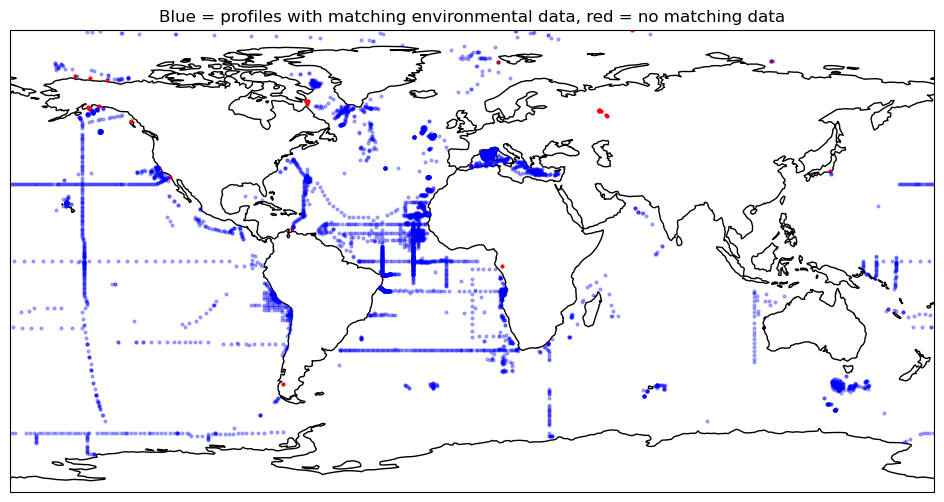

In [36]:
import xarray as xr
import numpy as np  

# check how many NaN values are in each column
print("\nMissing values per column:")
print(data.isna().sum())

# check how many unique Profile_ids have NaN values in columns ph to so_mean
env_vars = ['ph', 'chl', 'no3', 'po4', 'si', 'o2', 'fe', 'phyc', 'thetao_mean', 'so_mean']
for var in env_vars:
    n_profiles_with_nan = data[data[var].isna()]['Profile_id'].nunique()
    print(f"Profiles with NaN in {var}: {n_profiles_with_nan}")
# 166 profiles have at least one NaN value in any of the environmental variables

# check for Profiles which have only NaN values across all depth levels for at least one variable
profiles_with_all_nan = set()
for var in env_vars:
    all_nan_profiles = data[data[var].isna()]['Profile_id'].unique()
    profiles_with_all_nan.update(all_nan_profiles)
print(f"\nProfiles with all NaN values in at least one variable: {len(profiles_with_all_nan)}")

# show where these profiles are located on a global map
# add other profile locations in blue for context

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
for profile_id in profiles_with_all_nan:
    profile_data = data[data['Profile_id'] == profile_id]
    lat = profile_data['Latitude'].iloc[0]
    lon = profile_data['Longitude'].iloc[0]
    ax.plot(lon, lat, marker='o', color='red', markersize=2, transform=ccrs.PlateCarree())
for profile_id in data['Profile_id'].unique():
    if profile_id not in profiles_with_all_nan:
        profile_data = data[data['Profile_id'] == profile_id]
        lat = profile_data['Latitude'].iloc[0]
        lon = profile_data['Longitude'].iloc[0]
        ax.plot(lon, lat, marker='o', color='blue', markersize=2, alpha=0.3, transform=ccrs.PlateCarree())
plt.title('Blue = profiles with matching environmental data, red = no matching data')
plt.show()

In [37]:
# 83 profiles could not be matched to Copernicus Marine data due to location/time issues/ too close to coastlines
# remove these profiles from the dataset
data_cleaned = data[~data['Profile_id'].isin(profiles_with_all_nan)].reset_index(drop=True)
print(f"\nCleaned data shape: {data_cleaned.shape}")
# number of profiles should now be 5696 - 83 = 5613
print(f"Unique profiles after cleaning: {data_cleaned['Profile_id'].nunique()}")
# expected number remaining (5614)

# save cleaned data to new pickle file
output_path_cleaned = "../../Data/environmental_profiles_interpolated_cleaned.pkl"
data_cleaned.to_pickle(output_path_cleaned)
print(f"✅ Cleaned data saved to: {output_path_cleaned}")

# check number of non-unique Profile_id x depth combinations
duplicate_combinations = data_cleaned.duplicated(subset=['Profile_id', 'depth'], keep=False)
n_duplicates = duplicate_combinations.sum()
print(f"\nNumber of duplicate Profile_id x depth combinations: {n_duplicates}")
# number of profiles involved in duplicates
duplicate_profile_ids = data_cleaned[duplicate_combinations]['Profile_id'].unique()
print(f"Number of profiles involved in duplicates: {len(duplicate_profile_ids)}")


Cleaned data shape: (224520, 15)
Unique profiles after cleaning: 5613
✅ Cleaned data saved to: ../../Data/environmental_profiles_interpolated_cleaned.pkl

Number of duplicate Profile_id x depth combinations: 0
Number of profiles involved in duplicates: 0


# Match Biovolume and environmental data
- so that the same profiles are in both datasets

In [39]:
import pandas as pd
# features data and metadata(matching Profile_ids, depths and size classes to index)
features_data = pd.read_pickle("../../Data/BV_1000_max_25_bins_outliers_removed_cleaned.pkl")
features_data["Profile_id"] = features_data["Profile_id"].astype(str)
features_data.info()

# environmental labels data (matching environmental data to Profile_ids and depths)
labels_data = pd.read_pickle("../../Data/environmental_profiles_interpolated_cleaned.pkl")
labels_data["Profile_id"] = labels_data["Profile_id"].astype(str)
labels_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 227840 entries, 0 to 249575
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Profile_id                             227840 non-null  object 
 1   depth_bin                              227840 non-null  int64  
 2   Biovolume [ppm] (ESD: 0.203-0.256 mm)  227840 non-null  float64
 3   Biovolume [ppm] (ESD: 0.256-0.323 mm)  227840 non-null  float64
 4   Biovolume [ppm] (ESD: 0.323-0.406 mm)  227840 non-null  float64
 5   Biovolume [ppm] (ESD: 0.406-0.512 mm)  227840 non-null  float64
 6   Biovolume [ppm] (ESD: 0.512-0.645 mm)  227840 non-null  float64
 7   Biovolume [ppm] (ESD: 0.645-0.813 mm)  227840 non-null  float64
 8   Biovolume [ppm] (ESD: 0.813-1.02 mm)   227840 non-null  float64
 9   Biovolume [ppm] (ESD: 1.02-1.29 mm)    227840 non-null  float64
 10  Biovolume [ppm] (ESD: 1.29-1.63 mm)    227840 non-null  float

In [41]:
# subset features_data to only include Profile_ids present in labels_data
matched_features_data = features_data[features_data["Profile_id"].isin(labels_data["Profile_id"].unique())].reset_index(drop=True)

# check shape of both datasets
print(f"Matched features data shape: {matched_features_data.shape}")
print(f"Labels data shape: {labels_data.shape}")

# change name of bin_center_dbar in features to depth to match features data and move to first column
matched_features_data = matched_features_data.rename(columns={"bin_center_dbar": "depth"})
matched_features_data = matched_features_data[["Profile_id", "depth"] + [col for col in matched_features_data.columns if col not in ["Profile_id", "depth"]]]
matched_features_data.info()

# save matched features data to new pickle file
output_path_matched_features = "../../Data/Biovolume_per_size_class_and_depth_updated.pkl"
matched_features_data.to_pickle(output_path_matched_features)
print(f"\nMatched features data saved to: {output_path_matched_features}")

Matched features data shape: (224520, 20)
Labels data shape: (224520, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224520 entries, 0 to 224519
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Profile_id                             224520 non-null  object 
 1   depth                                  224520 non-null  float64
 2   depth_bin                              224520 non-null  int64  
 3   Biovolume [ppm] (ESD: 0.203-0.256 mm)  224520 non-null  float64
 4   Biovolume [ppm] (ESD: 0.256-0.323 mm)  224520 non-null  float64
 5   Biovolume [ppm] (ESD: 0.323-0.406 mm)  224520 non-null  float64
 6   Biovolume [ppm] (ESD: 0.406-0.512 mm)  224520 non-null  float64
 7   Biovolume [ppm] (ESD: 0.512-0.645 mm)  224520 non-null  float64
 8   Biovolume [ppm] (ESD: 0.645-0.813 mm)  224520 non-null  float64
 9   Biovolume [ppm] (ESD: 0.813-1.02 mm)   224520 non-n

In [43]:
# change lavels_data column order to have Profile_id and depth first
labels_data = labels_data[["Profile_id", "depth"] + [col for col in labels_data.columns if col not in ["Profile_id", "depth"]]]
labels_data.info()
#matched_features_data.info()

# save labels_data to new pickle file 
output_path_labels = "../../Data/Environmental_data_depth_resolved_updated.pkl"
labels_data.to_pickle(output_path_labels)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224520 entries, 0 to 224519
Data columns (total 15 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Profile_id   224520 non-null  object        
 1   depth        224520 non-null  float64       
 2   Latitude     224520 non-null  float64       
 3   Longitude    224520 non-null  float64       
 4   datetime     224520 non-null  datetime64[ns]
 5   ph           224520 non-null  float64       
 6   chl          224520 non-null  float64       
 7   no3          224520 non-null  float64       
 8   po4          224520 non-null  float64       
 9   si           224520 non-null  float64       
 10  o2           224520 non-null  float64       
 11  fe           224520 non-null  float64       
 12  phyc         224520 non-null  float64       
 13  thetao_mean  224520 non-null  float64       
 14  so_mean      224520 non-null  float64       
dtypes: datetime64[ns](1), float64(13),